In [1]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from matplotlib import rcParams
from scipy.stats import spearmanr, kendalltau, pearsonr
import random
from sklearn.metrics import r2_score
import math
from scipy import stats
from matplotlib import gridspec
import pandas as pd
import seaborn as sns
import scipy   
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2


def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 

    if normalized == 1: distr = distr/float(np.sum(distr)) 

    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())


def getPercentileBinnedDistribution(x, y, nbins):

    x, y = zip(*sorted(zip(x, y), key=lambda tup: tup[0]))
    elements_per_bin = int(len(x)/float(nbins))

    xx  = [np.mean(x[i*elements_per_bin:(i+1)*elements_per_bin]) for i in range(nbins)]
    yy  = [np.mean(y[i*elements_per_bin:(i+1)*elements_per_bin]) for i in range(nbins)]
    std = [np.std(y[i*elements_per_bin:(i+1)*elements_per_bin])  for i in range(nbins)]

    return xx, yy, std


def getLogBinnedDistribution(x, y, nbins):

    bins   = 10 ** np.linspace(np.log10(min(x)), np.log10(max(x)), nbins)  
    values = [ np.mean([y[j]  for j in range(len(x)) if x[j] >= bins[i] and x[j] < bins[i+1]])  for i in range(nbins-1)]    
    error  = [ np.std( [y[j]  for j in range(len(x)) if x[j] >= bins[i] and x[j] < bins[i+1]])  for i in range(nbins-1)]
    bins   = (bins[1:] + bins[:-1])/2

    return bins, values, error


def format_axis(ax):
    
    for pos in ['right', 'top', 'left']:
        ax.spines[pos].set_edgecolor('white')    

    ax.tick_params(axis='x', length=6, width=2, colors='black')
    ax.tick_params(axis='y', length=6, width=2, colors='black') 



field_title = { 'director':      'Movie directors',
                'art-director':  'Movie art directors',
                'producer':      'Movie producers' ,
                'composer':      'Soundtrack composers',
                'writer':        'Plot writers',
                'authors':       'Book authors',
                'electro':       'Electronic music artists', 
                'rock':          'Rock musicians',
                'pop':           'Pop musicians',
                'jazz':          'Jazz musicians',
                'folk':          'Folk musicians',
                'funk':          'Funk musicians',
                'hiphop':        'Hip-hop artists',
                'classical':     'Classical musicians',
               } 

# Check the impact distribution

Just for quick sanity check, with log binning and without fitting here. 

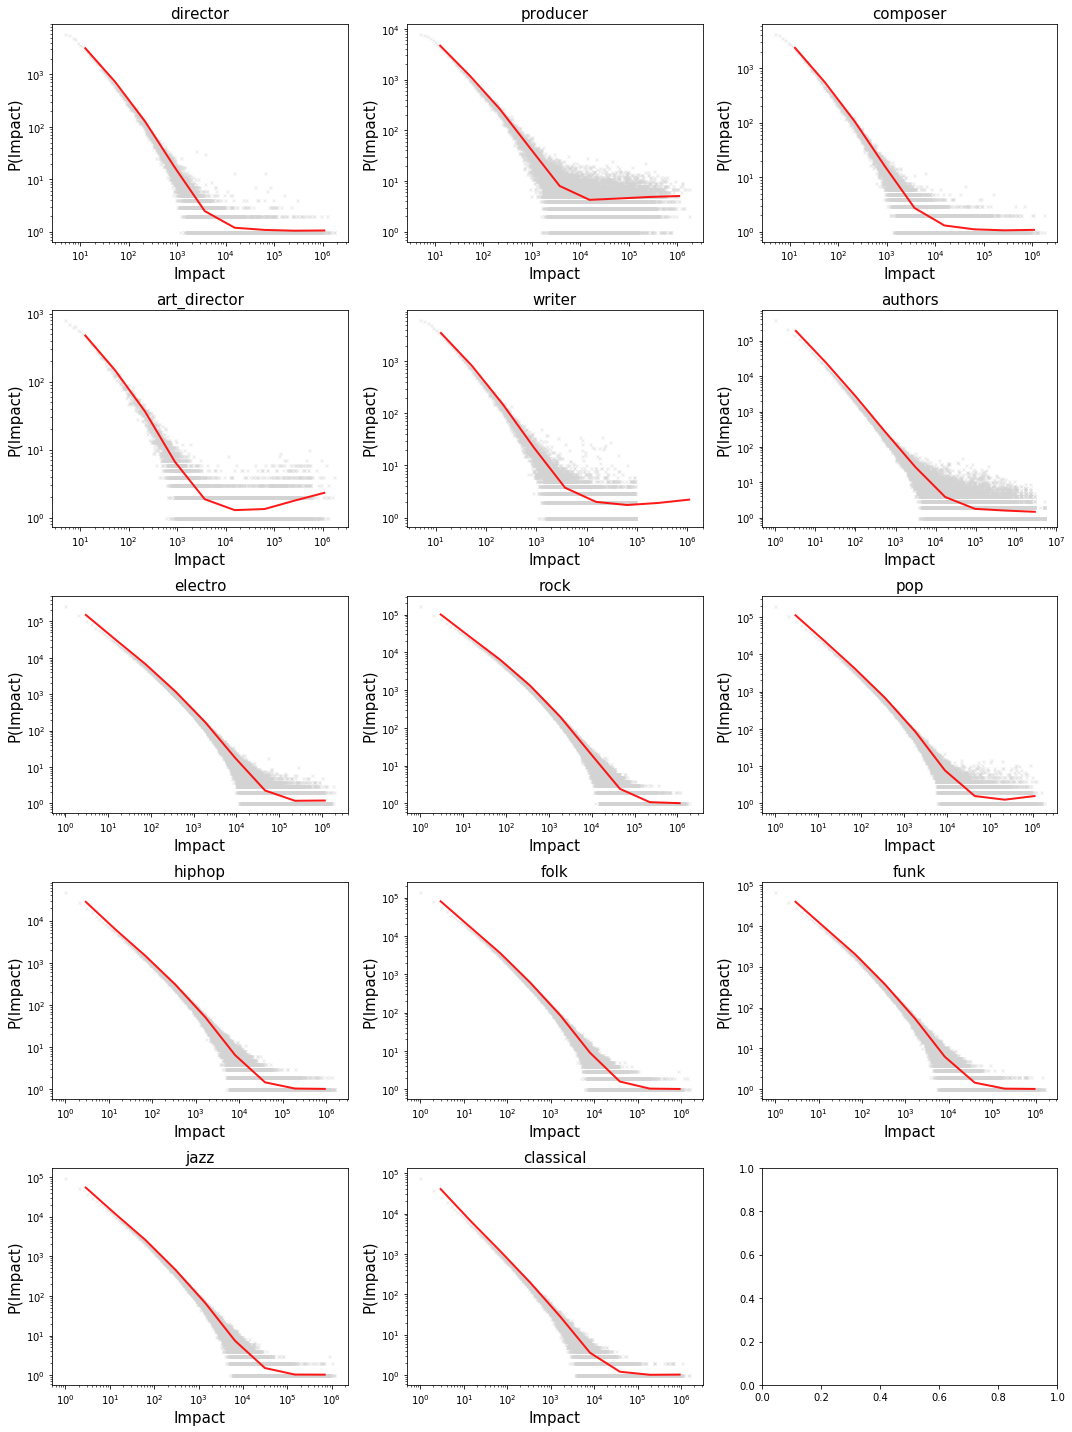

In [4]:
def plot_impact_distr(field, ax):
    
    ibinned = 'DataToPlot/1_impact_distribution/1_impact_distribution_binned_' + field + '.dat'
    idata   = 'DataToPlot/1_impact_distribution/1_impact_distribution_data_'   + field + '.dat'

    bx, by = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])  for line in open(ibinned) ])
    x,  y  = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])  for line in open(idata) ])

    ax.plot(x,  y, 'o', marker = 'x', markersize = 3, color = 'lightgrey', alpha = 0.4)
    ax.plot(bx, by, color = 'r', alpha = 0.9, linewidth = 2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(field.split('-')[0], fontsize = 15)

    ax.set_xlabel('Impact', fontsize = 15)
    ax.set_ylabel('P(Impact)', fontsize = 15)
    
f, ax = plt.subplots(5,3, figsize = (15,20))
plot_impact_distr('director-10',     ax[0,0])  
plot_impact_distr('producer-10',     ax[0,1]) 
plot_impact_distr('composer-10',     ax[0,2])  
plot_impact_distr('art_director-10', ax[1,0]) 
plot_impact_distr('writer-10',       ax[1,1])  
plot_impact_distr('authors-10',      ax[1,2])

plot_impact_distr('electro-20',    ax[2,0])
plot_impact_distr('rock-20',       ax[2,1])
plot_impact_distr('pop-20',        ax[2,2])
plot_impact_distr('hiphop-20',     ax[3,0])
plot_impact_distr('folk-20',       ax[3,1])
plot_impact_distr('funk-20',       ax[3,2])
plot_impact_distr('jazz-20',       ax[4,0])
plot_impact_distr('classical-20',  ax[4,1])

plt.tight_layout()


In [ ]:
   
def plot_impact(ax, title, label, color):    

    (xplog, yplog) = zip(*[tuple(float(ijk) for ijk in line.strip().split('\t'))  for line in open('ResultData/1_impact_distributions/'+ label + '_impact_distributions_powerlaw_hist.dat') ])
    (xlog,  ylog)  = zip(*[tuple(float(ijk) for ijk in line.strip().split('\t'))  for line in open('ResultData/1_impact_distributions/' + label + '_impact_distributions_lognormal.dat') ])

    (xpow,  ypow)  = zip(*[tuple(float(ijk) for ijk in line.strip().split('\t'))  for line in open('ResultData/1_impact_distributions/' + label + '_impact_distributions_powerlaw_fit.dat') ])


    ax.plot(xplog, yplog, '-', color = color, alpha = 0.30, linewidth = 10, label = 'data')
    ax.plot(xlog,  ylog,'-', color = color, linewidth = 2, label = 'lognormal')
    
    ax.set_ylim([min(yplog), 2])

    ax.tick_params(axis='both', which='major', pad=2)
    ax.legend(loc = 'left', fontsize = 12, frameon = False)
    for pos in ['right', 'top', 'left']: ax.spines[pos].set_edgecolor('white')    

    ax.tick_params(axis='x', length=6, width=2, colors='black')
    ax.tick_params(axis='y', length=6, width=2, colors='black')       
    ax.legend(loc = 'lower left', fontsize = 10)    
    

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Normalized rating count', fontsize = LABLEFONT, labelpad=50)
    ax.set_ylabel('CDF', fontsize = LABLEFONT)
    ax.set_title(title, fontsize = TITLEFONT)


        
'''fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

for i in range(2):
    ax[j].tick_params(axis='both', which='major', pad=21)
        
xoff = -0.28
        
ax[0].annotate("a)", xy=(xoff, 1.0), xycoords="axes fraction", fontsize = 12)
ax[1].annotate("b)", xy=(xoff, 1.0), xycoords="axes fraction", fontsize = 12)
ax[2].annotate("c)", xy=(xoff, 1.0), xycoords="axes fraction", fontsize = 12)

plot_impact(ax[0], 'Movie directors',  'director', 'steelblue')
plot_impact(ax[1], 'DJs',              'electro',  'darkred') 
'''
#plot_impact(ax[2], 'Book authors',     'authors',  'darkgreen') 
'''
ax[0].legend(loc = 'left', fontsize = 13)
ax[1].legend(loc = 'left', fontsize = 13)
ax[2].legend(loc = 'left', fontsize = 13)

plt.tight_layout()
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/S1.png')
plt.show()
'''
    
    

# R-rule - N*/N plots

The numbers indicate the lower cutoff of the career lengths, errorbars are the stdev of values within the bins. Probably better binning could make it nicer, now its just linear binning.

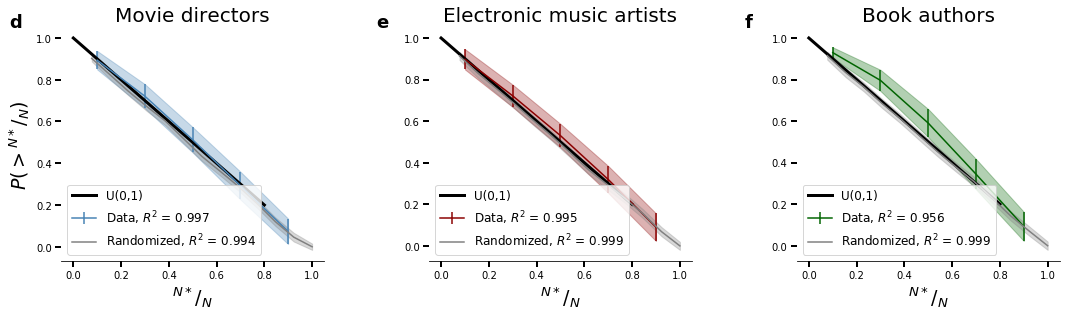

In [2]:
def get_N_star_N_plot_new(field, limn, title, ax, color, labelfont = 19, titlefont = 20, legendfont = 12):
    

    Rxx, Ryy, Ryerr = zip(*[ (float(fff) for fff in line.strip().split('\t')) for line in open('DataToPlot/2_N_Nstar/' + field.replace('-','_') + '-'+limn+'_RNNstar_data.dat' )])
    xx,  yy,  yerr  = zip(*[ (float(fff) for fff in line.strip().split('\t')) for line in open('DataToPlot/2_N_Nstar/' + field + '_NNstar_data.dat' )])
             
    x  = np.arange(0,1, 0.2)
    y  = [1.0 -  xi for xi in x]  
    XX = [1.0 - xxx for xxx in xx]
 
    #print r2_score(yy, y)


    DataAvg = np.mean(yy)
    RSStot  = sum([(YY - DataAvg)**2 for YY in yy])
    RSSres  = sum([(XX[i] - yy[i])**2 for i in range(len(yy) )])
    R2R     = str(round(1 - RSSres/RSStot, 3))

    
    RDataAvg = np.mean(yy)
    RXX = [1.0 - xxx for xxx in Rxx]

    RRSStot = sum([(YY - RDataAvg)**2 for YY in Ryy])
    RRSSres = sum([(RXX[i] - Ryy[i])**2 for i in range(len(Ryy) )])
    RR2R    = str(round(1 - RRSSres/RRSStot, 3))
    
    

    ax.plot(x,y, color ='k', linewidth = 3, alpha = 1.0, label= 'U(0,1)')
    ax.errorbar(xx, yy, yerr = yerr, color = color, label = 'Data, $R^2$ = ' + R2R)  
    ax.fill_between(xx, np.asarray(yy)- np.asarray(yerr), np.asarray(yy) + np.asarray(yerr), color = color, alpha = 0.3)

    ax.errorbar(Rxx, Ryy,  color = 'grey', label = 'Randomized, $R^2$ = ' + RR2R)  
    ax.fill_between(Rxx, np.asarray(Ryy)- np.asarray(Ryerr), np.asarray(Ryy) + np.asarray(Ryerr), color = 'grey', alpha = 0.3)

    
    ax.set_title(title, fontsize = titlefont) 
    ax.set_ylabel('$P(>^{N*}/{_N})$', fontsize = labelfont)
    ax.set_xlabel('$^{N*}/{_N}$', fontsize = labelfont)
    
 
    ax.legend(loc = 'lower left', fontsize = legendfont)
    format_axis(ax)
   


f, ax = plt.subplots(1,3, figsize = (15,4.5))

get_N_star_N_plot_new('director', '10',  field_title['director'], ax[0], 'steelblue')
get_N_star_N_plot_new('electro',  '80',  field_title['electro'], ax[1], 'darkred')
get_N_star_N_plot_new('authors',  '50',  field_title['authors'], ax[2], 'darkgreen')

plt.tight_layout()

ax[0].annotate("d", xy=(-0.2, 1.0), xycoords="axes fraction", fontsize = 18,     weight="bold")
ax[1].annotate("e", xy=(-0.2, 1.0), xycoords="axes fraction", fontsize = 18,     weight="bold")
ax[2].annotate("f", xy=(-0.2, 1.0), xycoords="axes fraction", fontsize = 18,     weight="bold")


for i in range(1,3):
    ax[i].set_ylabel('')

    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
    

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F2.png')

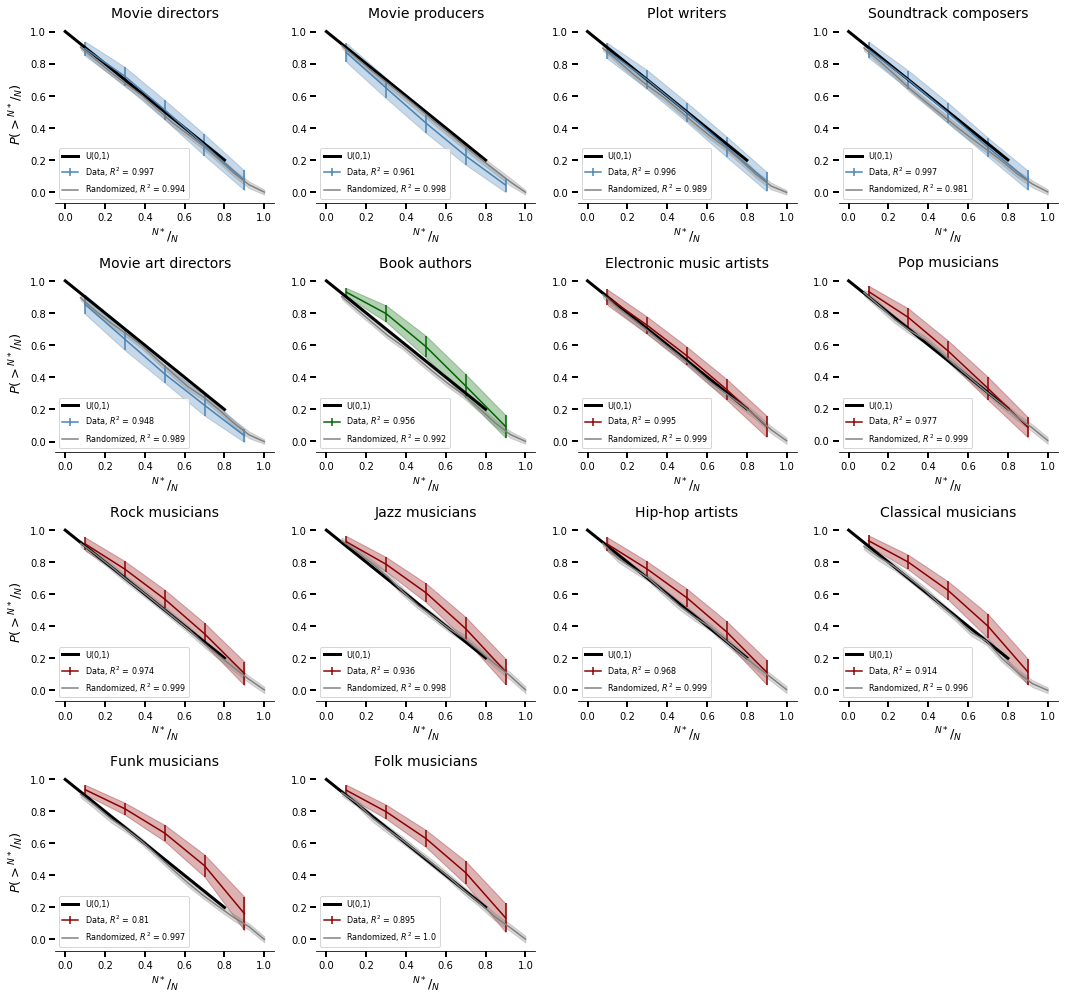

In [90]:
f, ax = plt.subplots(4,4,figsize = (15,14)) 

get_N_star_N_plot_new('director',     '10',  field_title['director'],     ax[0,0], 'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('producer',     '20',  field_title['producer'],     ax[0,1], 'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('writer',       '10',  field_title['writer'],       ax[0,2], 'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('composer',     '10',  field_title['composer'],     ax[0,3], 'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('art-director', '10',  field_title['art-director'], ax[1,0], 'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('authors',      '10',  field_title['authors'],      ax[1,1], 'darkgreen', labelfont = 13, titlefont = 14, legendfont = 8)

get_N_star_N_plot_new('electro',   '80', field_title['electro'],   ax[1,2], 'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('pop',       '80', field_title['pop'],       ax[1,3], 'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('rock',      '80',field_title['rock'],       ax[2,0], 'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('jazz',      '80',field_title['jazz'],       ax[2,1], 'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('hiphop',    '80',field_title['hiphop'],     ax[2,2], 'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('classical', '80',field_title['classical'],  ax[2,3], 'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('funk',      '80',field_title['funk'],       ax[3,0], 'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
get_N_star_N_plot_new('folk',      '80',field_title['folk'],       ax[3,1], 'darkred', labelfont = 13, titlefont = 14, legendfont = 8)

[ax[j,i].set_ylabel('') for i in range(1,4)  for j in range(4)]
ax[3,2].axis('off')
ax[3,3].axis('off')

plt.tight_layout()

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/rirfull.png')

# Career length distribution

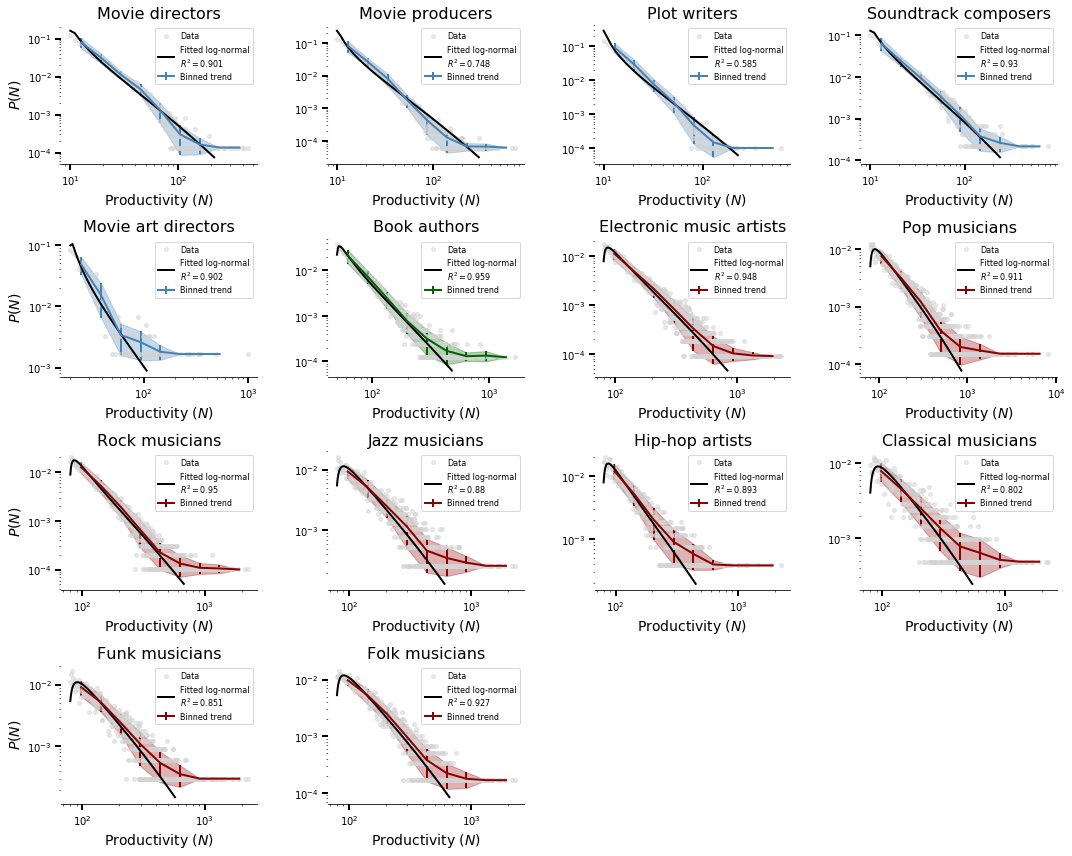

In [94]:
def plot_career_lengths(field, field_title, ax, color):

    nbins = 10
    careerlengths = [float(line.strip().split('\t')[1]) for line in open('IdData/' + field + '_career_length.dat')]
    xlen, plen    = getDistribution(careerlengths)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
   
    bxlen, bplen, bplenerr = getLogBinnedDistribution(xlen, plen, nbins)
    ax.set_title(field_title[field.rsplit('-', 1)[0]] , fontsize = 16)    
    
    ax.set_ylabel('$P(N)$', fontsize = 14)
    ax.set_xlabel('Productivity ($N$)', fontsize = 14)
    
    format_axis(ax)       
    ax.legend(loc = 'lower left', fontsize = 10)
    
    
    p0    = stats.lognorm._fitstart(careerlengths)
    p1    = stats.lognorm.fit(careerlengths, p0[0], loc  = p0[1],scale = p0[2])
    param = stats.lognorm.fit(careerlengths, p1[0], loc  = p1[1],scale = p1[2])
    
    ppdf_fitted = stats.lognorm.pdf(xlen, param[0], loc=param[1], scale=param[2])
    Qxpp, ppdf_fittedpp = zip(*[(xlen[i], ppdf_fitted[i]) for i in range(len(ppdf_fitted)) if ppdf_fitted[i] > 0.5 * min(plen)])
    
    DataAvg = np.mean(plen)
    RSStot  = sum([(YY - DataAvg)**2 for YY in plen])
    RSSres  = sum([(plen[i] - ppdf_fitted[i])**2 for i in range(len(plen) )])
    R2R     = str(round(1 - RSSres/RSStot, 3))


    ax.plot(xlen, plen, 'o', color = 'lightgrey', alpha = 0.5, linewidth = 0, markersize = 4, label = 'Data')
    ax.errorbar(bxlen, bplen,  yerr = bplenerr, linewidth = 2, color = color, label = 'Binned trend')
    ax.fill_between(bxlen, np.asarray(bplen)- np.asarray(bplenerr), np.asarray(bplen) + np.asarray(bplenerr), color = color, alpha = 0.3)
    ax.plot(Qxpp, ppdf_fittedpp, color = 'k', linewidth = 2, label = 'Fitted log-normal\n$R^2 = $' + str(R2R))

    ax.legend(loc = 'upper right', fontsize = 8)

    
f, ax = plt.subplots(4,4,figsize = (15,12))    
    
plot_career_lengths('director-10',     field_title, ax[0,0], 'steelblue')
plot_career_lengths('producer-10',     field_title, ax[0,1], 'steelblue')
plot_career_lengths('writer-10',       field_title, ax[0,2], 'steelblue')
plot_career_lengths('composer-10',     field_title, ax[0,3], 'steelblue')
plot_career_lengths('art-director-20', field_title, ax[1,0], 'steelblue')
plot_career_lengths('authors-50',      field_title, ax[1,1], 'darkgreen')
plot_career_lengths('electro-80',      field_title, ax[1,2], 'darkred')
plot_career_lengths('pop-80',          field_title, ax[1,3], 'darkred')
plot_career_lengths('rock-80',         field_title, ax[2,0], 'darkred')
plot_career_lengths('jazz-80',         field_title, ax[2,1], 'darkred')
plot_career_lengths('hiphop-80',       field_title, ax[2,2], 'darkred')
plot_career_lengths('classical-80',    field_title, ax[2,3], 'darkred')
plot_career_lengths('funk-80',         field_title, ax[3,0], 'darkred')
plot_career_lengths('folk-80',         field_title, ax[3,1], 'darkred')


ax[3,2].axis('off')
ax[3,3].axis('off')


plt.tight_layout()
[ax[j,i].set_ylabel('') for i in range(1,4) for j in range(4)] 

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/careerlengths.png')

# p and Q distributions

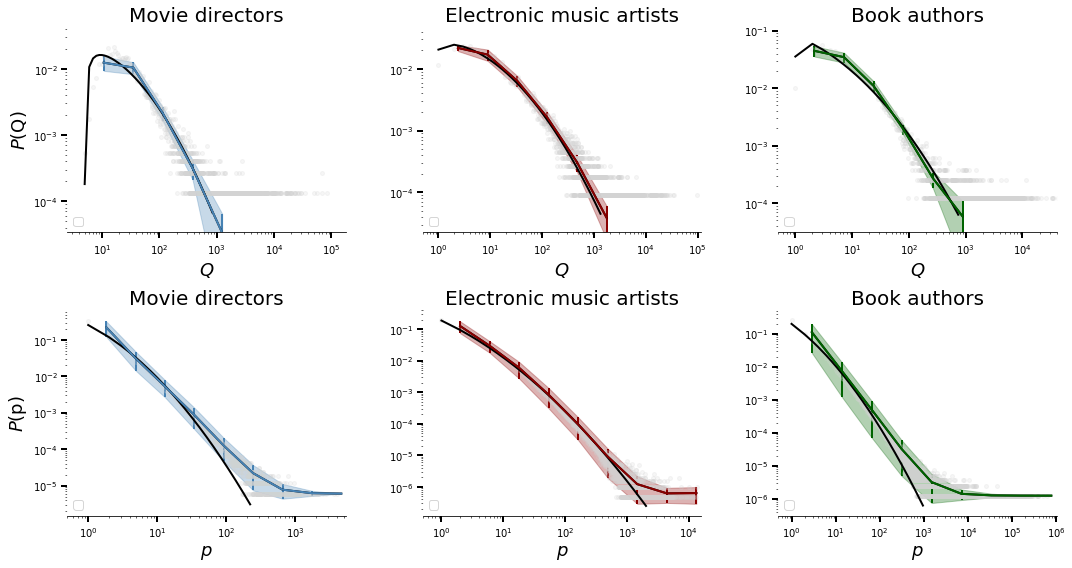

In [96]:
def do_p_Q_plots(field, bx, color, tipus, nbins, titlefont = 20, labelfont = 18, legendfont = 12):
    
    Qdata    = 'DataToPlot/3_pQ_distributions_processed/' + field + '_' + tipus + 'data.dat'
    Qfit     = 'DataToPlot/3_pQ_distributions_processed/' + field + '_' + tipus + 'fit.dat'
    Qbinned  = 'DataToPlot/3_pQ_distributions_processed/' + field + '_' + tipus + 'binned.dat'
      
        
    Qx,    Qy        = zip(*[ [float(fff) for fff in line.strip().split('\t')] for line in open(Qdata)])
    fQx,  fQy        = zip(*[ [float(fff) for fff in line.strip().split('\t')] for line in open(Qfit)])
    bQx,  bQy, berr  = zip(*[ [float(fff) for fff in line.strip().split('\t')] for line in open(Qbinned)])
  
    
    bx.plot(Qx,   Qy, 'o', color = 'lightgrey', alpha = 0.2, linewidth = 0, markersize = 4)
    bx.plot(fQx, fQy,      color = 'k', linewidth = 2)
    bx.errorbar(bQx, bQy,  yerr  = berr ,   color = 'k', linewidth = 2)
    bx.errorbar(bQx, bQy,  yerr = berr, linewidth = 2, color = color)
    bx.fill_between(bQx, np.asarray(bQy)- np.asarray(berr), np.asarray(bQy) + np.asarray(berr), color = color, alpha = 0.3)
      
    
    bx.set_xscale('log')
    bx.set_yscale('log')

    bx.set_ylim([0.25*min(Qy), 2*max(Qy)])
    bx.set_xlim([0.5*min(Qx), 0.8*max(Qx)])
    bx.set_ylabel('$P($' + tipus + '$)$', fontsize = labelfont)
    bx.set_xlabel('$' + tipus + '$', fontsize = labelfont)
      
    bx.legend(loc = 'lower left', fontsize = legendfont)

    format_axis(bx)

    bx.set_title(field_title[field.split('-')[0].replace('_', '-')], fontsize = titlefont)

 

    
f, ax = plt.subplots(2,3, figsize = (15,8,))

do_p_Q_plots('director-10', ax[0,0], 'steelblue', 'Q', 10) 
do_p_Q_plots('director-10', ax[1,0], 'steelblue', 'p', 10)

do_p_Q_plots('electro-80', ax[0,1], 'darkred', 'Q', 10) 
do_p_Q_plots('electro-80', ax[1,1], 'darkred', 'p', 10)

do_p_Q_plots('authors-50', ax[0,2], 'darkgreen', 'Q', 10) 
do_p_Q_plots('authors-50', ax[1,2], 'darkgreen', 'p', 10)

plt.tight_layout()

[ax[j,i].set_ylabel('') for i in range(1,3) for j in range(2)]

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F3.png')

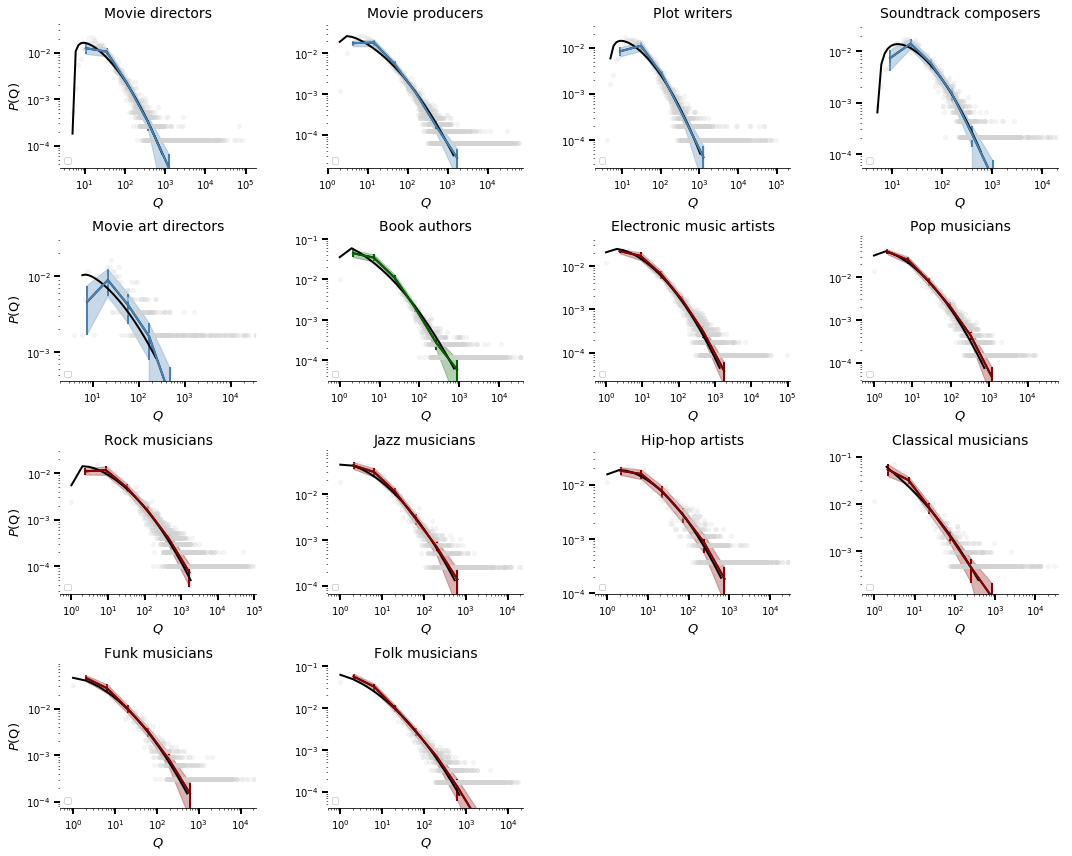

In [106]:
figQ, Qax = plt.subplots(4,4, figsize = (15,12))

do_p_Q_plots('director-10',     Qax[0,0], 'steelblue', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('producer-10',     Qax[0,1], 'steelblue', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8) 
do_p_Q_plots('writer-10',       Qax[0,2], 'steelblue', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8) 
do_p_Q_plots('composer-10',     Qax[0,3], 'steelblue', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8) 
do_p_Q_plots('art_director-20', Qax[1,0], 'steelblue', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('authors-50',      Qax[1,1], 'darkgreen', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)

do_p_Q_plots('electro-80',   Qax[1,2], 'darkred', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('pop-80',       Qax[1,3], 'darkred', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('rock-80',      Qax[2,0], 'darkred', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('jazz-80',      Qax[2,1], 'darkred', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('hiphop-80',    Qax[2,2], 'darkred', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('classical-80', Qax[2,3], 'darkred', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('funk-80',      Qax[3,0], 'darkred', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('folk-80',      Qax[3,1], 'darkred', 'Q', 10, labelfont = 13, titlefont = 14, legendfont = 8)

plt.tight_layout()
[Qax[j,i].set_ylabel('') for i in range(1,4) for j in range(4)]
       

Qax[3,2].axis('off')
Qax[3,3].axis('off')    
    
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/Qfitfull.png')

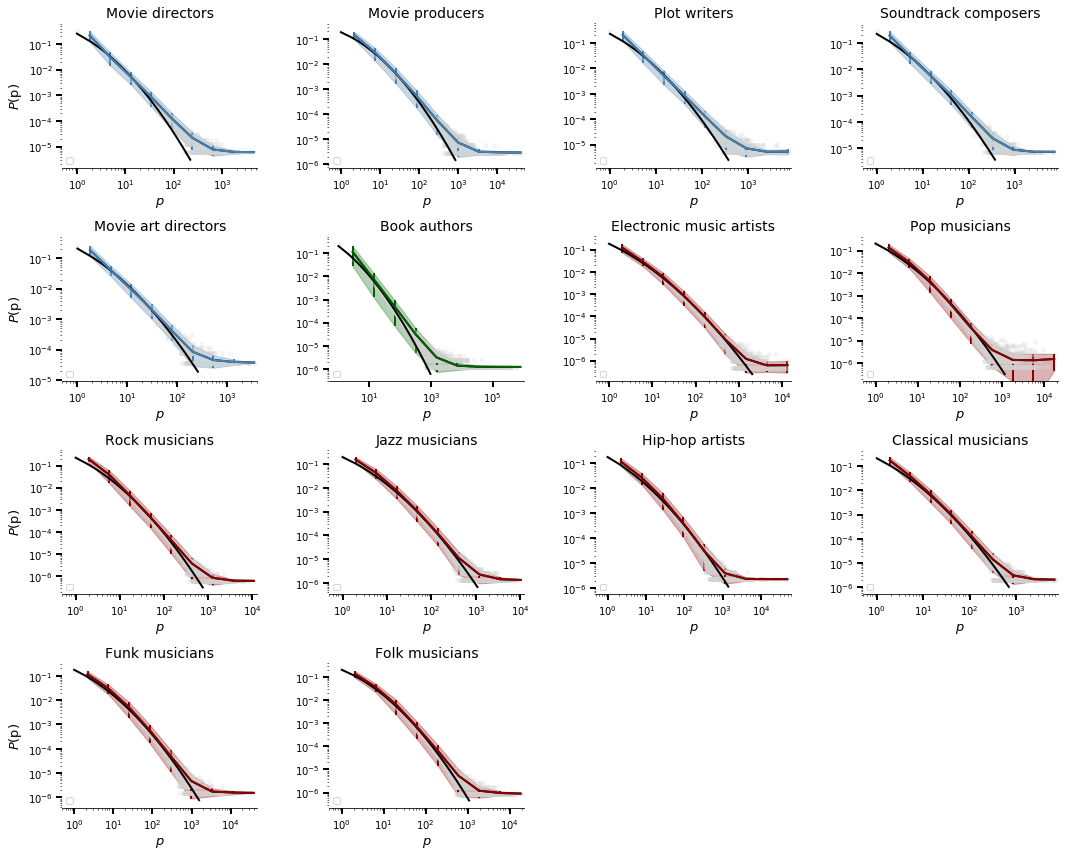

In [107]:
figp, pax = plt.subplots(4,4, figsize = (15,12))

do_p_Q_plots('director-10',     pax[0,0], 'steelblue', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('producer-10',     pax[0,1], 'steelblue', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8) 
do_p_Q_plots('writer-10',       pax[0,2], 'steelblue', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8) 
do_p_Q_plots('composer-10',     pax[0,3], 'steelblue', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8) 
do_p_Q_plots('art_director-20', pax[1,0], 'steelblue', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('authors-50',      pax[1,1], 'darkgreen', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)

do_p_Q_plots('electro-80',   pax[1,2], 'darkred', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('pop-80',       pax[1,3], 'darkred', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('rock-80',      pax[2,0], 'darkred', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('jazz-80',      pax[2,1], 'darkred', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('hiphop-80',    pax[2,2], 'darkred', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('classical-80', pax[2,3], 'darkred', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('funk-80',      pax[3,0], 'darkred', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)
do_p_Q_plots('folk-80',      pax[3,1], 'darkred', 'p', 10, labelfont = 13, titlefont = 14, legendfont = 8)

plt.tight_layout()
[pax[j,i].set_ylabel('') for i in range(1,4) for j in range(4)]
       

pax[3,2].axis('off')
pax[3,3].axis('off')    
    
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/pfitfull.png')

# Individual luck curves 

In [141]:
def get_luck_curves(field, ax, color, lim, mmin, labelfont = 17, titlefont = 20, legendfont = 12):
    
    data    = 'DataToPlot/3_pQ_distributions/p_values_of_users_' + field + '.dat'
    pvalues = {} 
    ijk     = 0
    
    for ind, line in enumerate(open(data)):
                 
        fields = line.strip().split('\t') 
        X = [float(x) for x in fields[1].split(';')]
        Y = [float(y) for y in fields[2].split(';')]
        
        if 'everybody' not in line:
            if len(X) > mmin and ijk < 50:
                if ijk == 8:
                    ax.plot(X,Y, linewidth = 1.0, color = 'lightgrey', alpha = 0.85, label = 'Individuals\' data')    

                ax.plot(X,Y, linewidth = 1.0, color = 'lightgrey', alpha = 0.25)    
                ijk += 1
        else:
            ax.plot(X,Y, linewidth = 3.5, alpha = 0.9, color = color, label = 'Aggregated data')        
 
       
    ax.set_xscale('log')
    ax.set_title(field_title[field.split('-')[0].replace('_', '-')], fontsize = titlefont)
    ax.set_xlim(lim)        
        
    ax.set_ylabel('P(> $p_{i,\\alpha}$)', fontsize = labelfont)
    ax.set_xlabel('$p_{i,\\alpha}$', fontsize = labelfont)    
    
    format_axis(ax)
    ax.legend(loc = 'lower left', fontsize = legendfont)
    field = field.split('-')[0] + ' N >= ' + field.split('-')[1].split('_')[0]

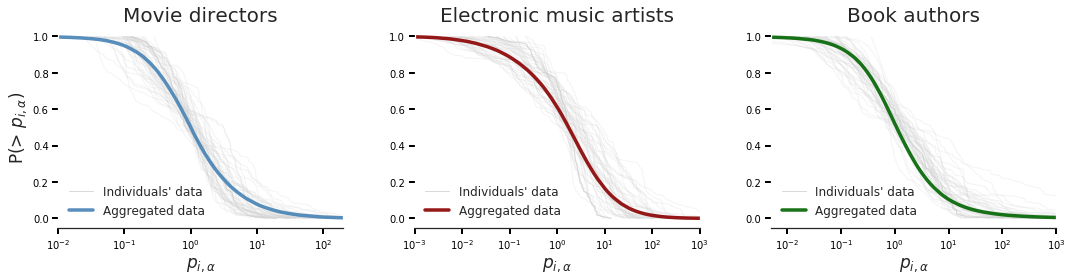

In [139]:
f, ax = plt.subplots(1,3, figsize = (15, 4))

get_luck_curves('director-10_0', ax[0], 'steelblue', [0.01,   200], 50)
get_luck_curves('electro-80_0',  ax[1], 'darkred',   [0.001, 1000], 50)
get_luck_curves('authors-10_0',  ax[2], 'darkgreen', [0.005, 1000], 50)

plt.tight_layout()
for i in range(1,3):
    ax[i].set_ylabel('')
    
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F5.png')

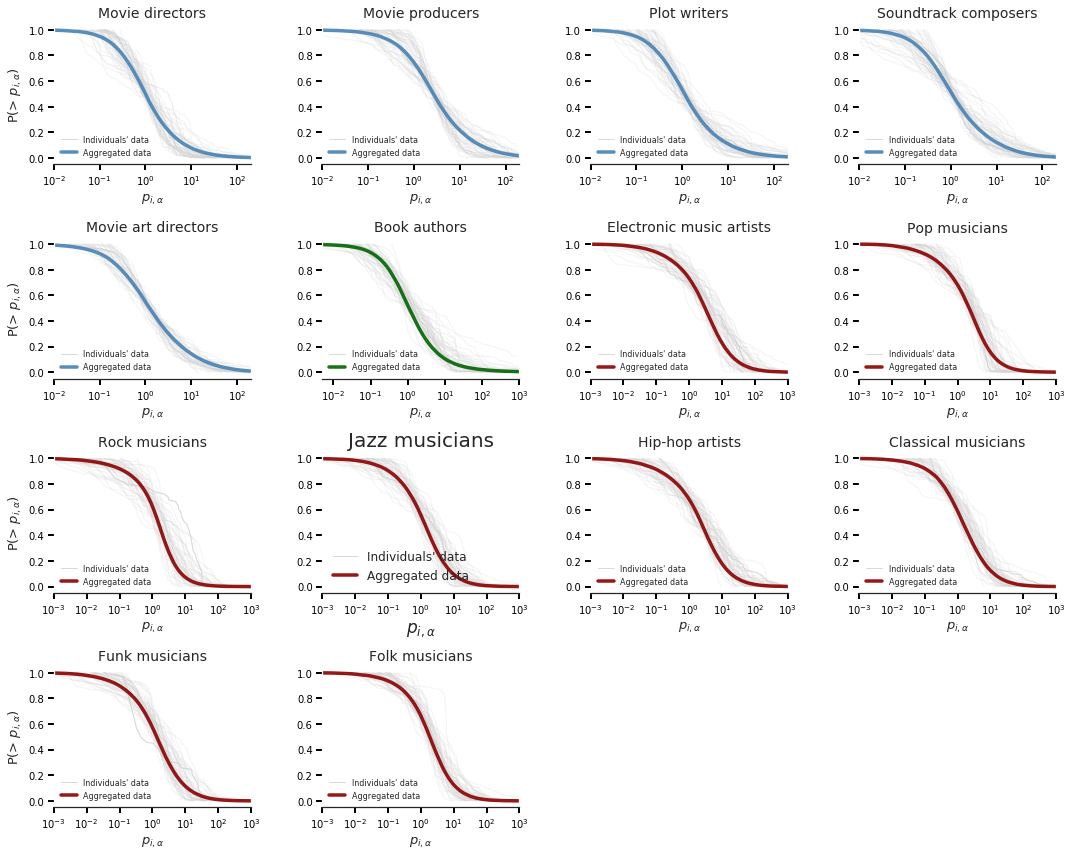

In [143]:
fig, ax = plt.subplots(4,4, figsize = (15,12))


get_luck_curves('director-10_0',     ax[0,0], 'steelblue', [0.01,   200], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('producer-10_0',     ax[0,1], 'steelblue', [0.01,   200], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('writer-10_0',       ax[0,2], 'steelblue', [0.01,   200], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('composer-10_0',     ax[0,3], 'steelblue', [0.01,   200], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('art_director-10_0', ax[1,0], 'steelblue', [0.01,   200], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('authors-10_0',      ax[1,1], 'darkgreen', [0.005, 1000], 50, labelfont = 13, titlefont = 14, legendfont = 8)

get_luck_curves('electro-20_0',   ax[1,2], 'darkred',   [0.001, 1000], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('pop-20_0',       ax[1,3], 'darkred',   [0.001, 1000], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('rock-20_0',      ax[2,0], 'darkred',   [0.001, 1000], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('jazz-20_0',      ax[2,1], 'darkred',   [0.001, 1000], 50)

get_luck_curves('hiphop-20_0',    ax[2,2], 'darkred',   [0.001, 1000], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('classical-20_0', ax[2,3], 'darkred',   [0.001, 1000], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('funk-20_0',      ax[3,0], 'darkred',   [0.001, 1000], 50, labelfont = 13, titlefont = 14, legendfont = 8)
get_luck_curves('folk-20_0',      ax[3,1], 'darkred',   [0.001, 1000], 50, labelfont = 13, titlefont = 14, legendfont = 8)


plt.tight_layout()
[ax[j,i].set_ylabel('') for i in range(1,4) for j in range(4)]
       
ax[3,2].axis('off')
ax[3,3].axis('off')    
    
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/luckfull.png')

# Fittin the R and Q models onto the N - I* data

The length of the career vs the impact of the highest impact piece (more precisely log I). I show two different career length cutoffs, indicating the number of users being included on each plot. I use 10 bins with logarithmic binning, and the best solutions from the optimization. I also tried differetn solutions from the optimization (e.g. top 5) - they all show similar results. At the end, the plots look very similar. Haven't done R^2 stats yet.

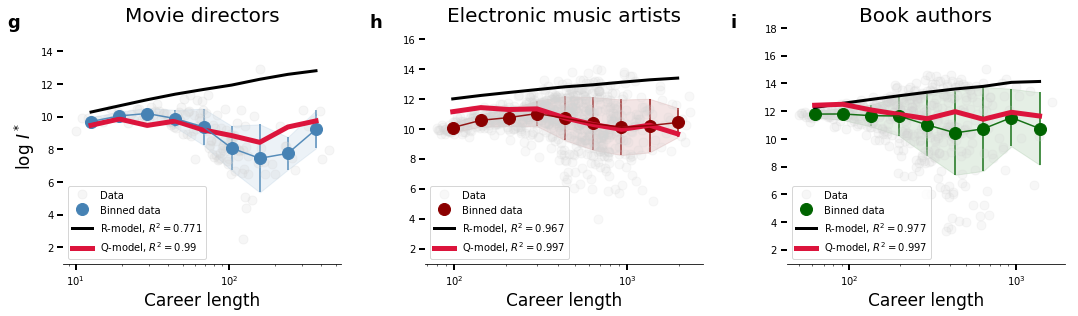

In [7]:
def plot_RQmodel(field, ax,  colors, labelfont = 17, titlefont = 20, legendfont = 10):

    root   = 'DataToPlot/4_RQModel/'
    data   = root + '4_RQModel_data_'   + field + '.dat'
    binned = root + '4_RQModel_binned_' + field + '.dat'
    rmodel = root + '4_RQModel_rmodel_' + field + '.dat'
    qmodel = root + '4_RQModel_qmodel_' + field + '.dat'

    x,    y     = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(data)    ])  
    bx,   by, e = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(binned)  ])
    bxR, byR    = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(rmodel)  ])
    bxQ, byQ    = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(qmodel)  ])

    
    NNN    = len(x)
    alpha_ = 1.0/math.log(NNN)
      
    DataAvg = np.mean(y)
    RAvg    = np.mean(byR)
    QAvg    = np.mean(byQ)
    
    QSStot = sum([(y[i]  - DataAvg)**2 for i in range(len(y))])
    QSSres = sum([(byQ[i] - DataAvg)**2 for i in range(len(byQ)) if 'nan' != str(byQ[i])])
       
    RSStot = sum([(y[i]   - DataAvg)**2 for i in range(len(y))])
    RSSres = sum([(byR[i] - DataAvg)**2 for i in range(len(byR)) if 'nan' != str(byR[i])])

    R2Q = round(1 - QSSres/QSStot, 3)
    R2R = round(1 - RSSres/RSStot, 3)

    
    ax.plot(x,  y,   'o', markersize = 9, alpha = alpha_, color = 'lightgrey', label = 'Data')
    ax.plot(bx, by,  'o', color = colors, markersize = 12, label = 'Binned data')
    ax.errorbar(bx, by, yerr = e, color = colors, markersize = 15, alpha = 0.9)

    ax.plot(bxR, byR ,  'k', linewidth = 3, label= 'R-model, $R^2=$' + str(R2R))
    ax.plot(bxQ, byQ , 'g', linewidth = 5, color = 'crimson', label = 'Q-model, $R^2=$' + str(R2Q))
    
    
    ax.set_xscale('log')
    ax.set_ylim([1, 1.2*max(y)])
    ax.set_xlabel('Career length', fontsize = labelfont)
    ax.set_ylabel('${\\rm log}$ $I^*$', fontsize = labelfont)
    ax.fill_between(bx, np.asarray(by)- np.asarray(e), np.asarray(by) + np.asarray(e), color =  colors, alpha = 0.1)

    format_axis(ax)     
    ax.legend(loc = 'lower left', fontsize = legendfont)

    field = field.split('-')[0].replace('_', '-')
    ax.set_title(field_title[field], fontsize = titlefont)

    

  
colors = {  'film' :  sns.color_palette("GnBu_d"),
            'book' :  sns.light_palette("green"),         
            'music' :  sns.light_palette("red")}


f, ax = plt.subplots(1,3, figsize = (15,4.5))
plot_RQmodel('director-10_0',  ax[0],  'steelblue'   )  
plot_RQmodel('electro-80_0',   ax[1], 'darkred'   )   
plot_RQmodel('authors-50_0',   ax[2], 'darkgreen')  

[ax[i].set_ylabel('') for i in range(1,3)]
    

ax[0].annotate("g", xy=(-0.2, 1.0), xycoords="axes fraction", fontsize = 18,     weight="bold")
ax[1].annotate("h", xy=(-0.2, 1.0), xycoords="axes fraction", fontsize = 18,     weight="bold")
ax[2].annotate("i", xy=(-0.2, 1.0), xycoords="axes fraction", fontsize = 18, weight="bold")

    
plt.tight_layout() 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F4.png')

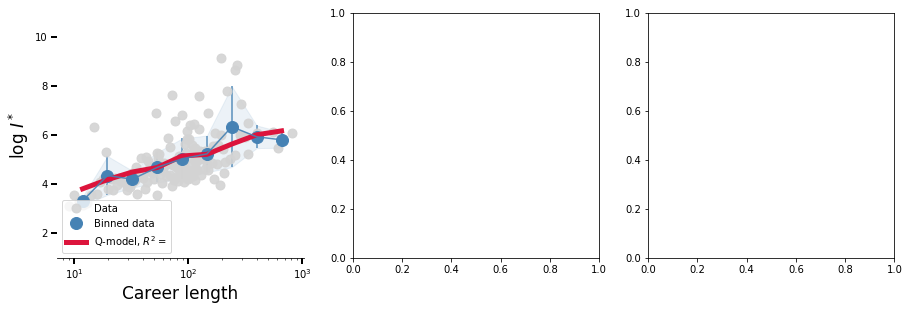

In [16]:
def plot_RQ(field, ax,  colors, labelfont = 17, titlefont = 20, legendfont = 10):

    alpha_= 0.9
    root   = 'DataToPlot/4_RQModel/'
    data   = root + '4_RQModel_data_'   + field + '.dat'
    binned = root + '4_RQModel_binned_' + field + '.dat'
    qmodel = root + '4_RQModel_qmodel_' + field + '.dat'

    x,    y     = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(data)    ])  
    bx,   by, e = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(binned)  ])
    bxQ, byQ    = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(qmodel)  ])

    
  
    ax.plot(x,  y,   'o', markersize = 9, alpha = alpha_, color = 'lightgrey', label = 'Data')
    ax.plot(bx, by,  'o', color = colors, markersize = 12, label = 'Binned data')
    ax.errorbar(bx, by, yerr = e, color = colors, markersize = 15, alpha = 0.9)

    ax.plot(bxQ, byQ , 'g', linewidth = 5, color = 'crimson', label = 'Q-model, $R^2=$')
    
    
    ax.set_xscale('log')
    ax.set_ylim([1, 1.2*max(y)])
    ax.set_xlabel('Career length', fontsize = labelfont)
    ax.set_ylabel('${\\rm log}$ $I^*$', fontsize = labelfont)
    ax.fill_between(bx, np.asarray(by)- np.asarray(e), np.asarray(by) + np.asarray(e), color =  colors, alpha = 0.1)

    format_axis(ax)     
    ax.legend(loc = 'lower left', fontsize = legendfont)

   
    


f, ax = plt.subplots(1,3, figsize = (15,4.5))
plot_RQ('mathematics-10_0',  ax[0],  'steelblue'   )  
plt.show() 


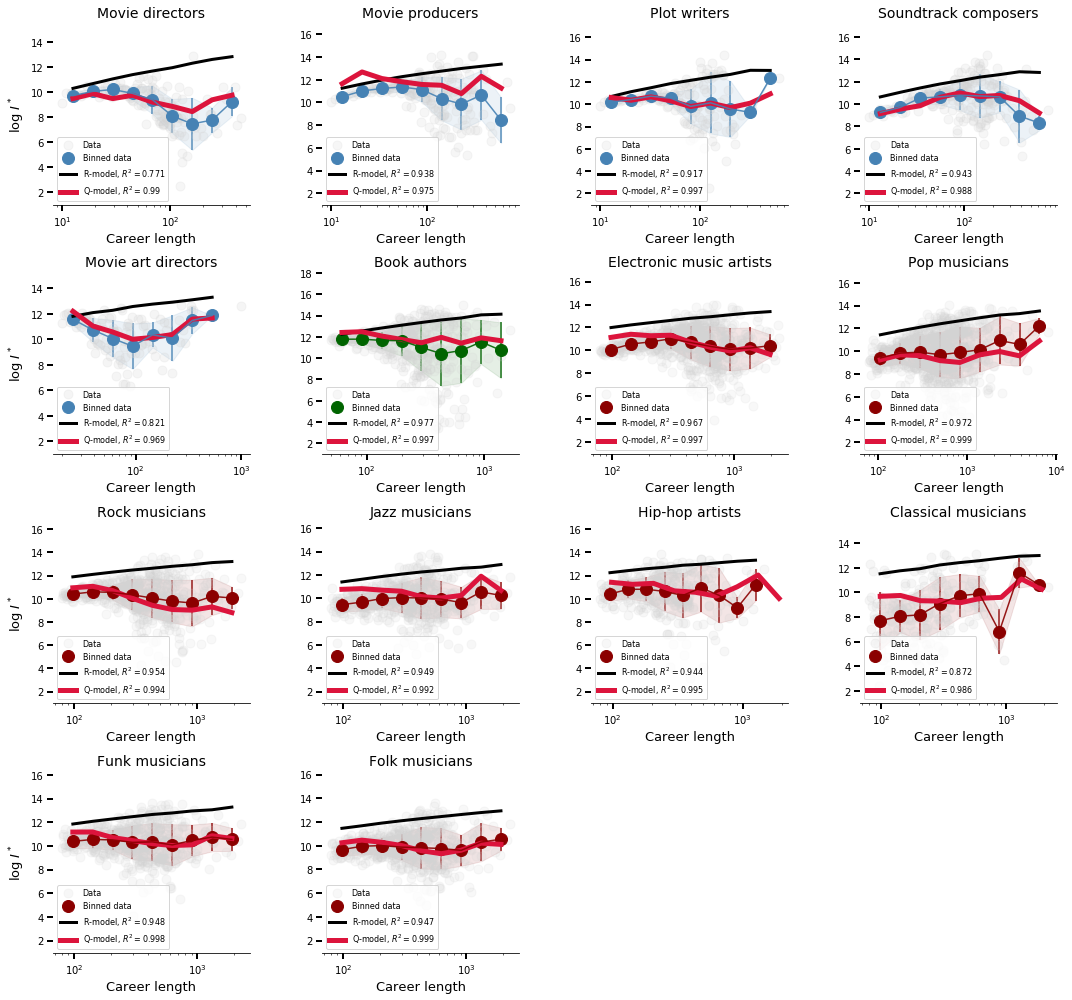

In [117]:
f, ax = plt.subplots(4,4,figsize = (15,14))  

plot_RQmodel('director-10_0',     ax[0,0],  'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('producer-10_0',     ax[0,1],  'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('writer-10_0',       ax[0,2],  'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('composer-10_0',     ax[0,3],  'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('art_director-20_0', ax[1,0],  'steelblue', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('authors-50_0',      ax[1,1],  'darkgreen', labelfont = 13, titlefont = 14, legendfont = 8)
    
plot_RQmodel('electro-80_0',   ax[1,2],  'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('pop-80_0',       ax[1,3],  'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('rock-80_0',      ax[2,0],  'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('jazz-80_0',      ax[2,1],  'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('hiphop-80_0',    ax[2,2],  'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('classical-80_0', ax[2,3],  'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('funk-80_0',      ax[3,0],  'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
plot_RQmodel('folk-80_0',      ax[3,1],  'darkred', labelfont = 13, titlefont = 14, legendfont = 8)
    
ax[3,2].axis('off')
ax[3,3].axis('off')

plt.tight_layout()
[ax[j,i].set_ylabel('') for i in range(1,4) for j in range(4)] 

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/RQtestfull.png')

# Luck and skill

In [34]:
fields = ['authors', 'art-director' , 'writer', 'director', 'composer', 'producer', 'pop', 'rock', 'classical', 'jazz', 'electro', 'funk', 'folk', 'hiphop']
Ns     = [50,  20, 10, 10, 10, 10, 80, 80, 80, 80, 80, 80, 80 ,80]

sillz = []

for ind, field in enumerate(fields):
    
    N = str(Ns[ind])


    ps = [float(line.strip().split('\t')[-1]) for line in open('pQData/p_distribution_'+field+'-'+N+'_0.dat')]
    Qs = [float(line.strip().split('\t')[-1]) for line in open('pQData/Q_distribution_'+field+'-'+N+'_0.dat')]
    logQs = [math.log(q) for q in Qs]
    logps = [math.log(p) for p in ps]
    print field, '\t', np.var(logQs) /(np.var(logQs) + np.var(logps))

    sillz.append(np.var(logQs) /(np.var(logQs) + np.var(logps)))   

authors 	0.4713318977291843
art-director 	0.5004462045962331
writer 	0.4172552305463674
director 	0.45640461169721713
composer 	0.3233142506797734
producer 	0.5050310577814168
pop 	0.45418860305430103
rock 	0.5443003713210512
classical 	0.5297343272129416
jazz 	0.47720037168724877
electro 	0.44579608874472537
funk 	0.46847159443999653
folk 	0.5314445743522257
hiphop 	0.4372700455450765


(array([1., 0., 1., 5., 4., 3.]),
 array([0.32331425, 0.36014527, 0.39697629, 0.43380731, 0.47063833,
        0.50746935, 0.54430037]),
 <a list of 6 Patch objects>)

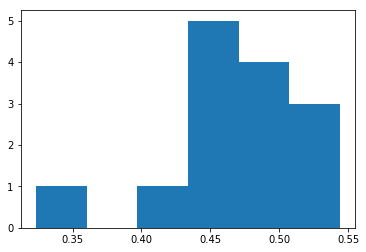

In [45]:
plt.hist(sillz, bins = 6)

In [3]:
colors_field =  {    'art_director': 'steelblue',
                     'authors'     : 'darkgreen', 
                     'classical'   : 'darkred',
                     'composer'    : 'steelblue',
                     'director'    : 'steelblue',
                     'electro'     : 'darkred',
                     'folk'        : 'darkred',
                     'funk'        : 'darkred',
                     'hiphop'      : 'darkred',
                     'jazz'        : 'darkred',
                     'pop'         : 'darkred',
                     'producer'    : 'steelblue',
                     'rock'        : 'darkred',
                     'writer'      : 'steelblue'}
pdata = {}
qdata = {}

for line in open('DataToPlot/5_LuckSkill/p_avg_std.dat'):
    if '0_0.dat' in line:
        line  = line.strip().split('\t')
        field = line[0].replace('p_distribution_', '').rsplit('_', 1)[0]
        pavg  = float(line[1])
        pstd  = float(line[2])
        pdata[field] = pstd# / pavg
        
        
for line in open('DataToPlot/5_LuckSkill/Q_avg_std.dat'):
    if '0_0.dat' in line:
        line  = line.strip().split('\t')
        field = line[0].replace('Q_distribution_', '').rsplit('_', 1)[0]
        qavg  = float(line[1])
        qstd  = float(line[2])                                                            
        qdata[field] = qstd / qavg
      
final_keys = ['art_director-20', 'authors-50','classical-80', 'composer-10', 'director-10', 'electro-80', 'folk-80',
             'funk-80', 'hiphop-80', 'jazz-80', 'pop-80', 'producer-10', 'rock-80', 'writer-10' ]

luck_skill_data = {}

for field in final_keys:   
    luck_skill_data[field.split('-')[0]] =  qdata[field] / pdata[field] 
    
luck_skill_data

{'art_director': 0.0398250928120754,
 'authors': 0.0017857669822759026,
 'classical': 0.08948965376613013,
 'composer': 0.0542577984135833,
 'director': 0.21817089360636718,
 'electro': 0.06600899286104,
 'folk': 0.04831984282760547,
 'funk': 0.03131175253896466,
 'hiphop': 0.021863323430344125,
 'jazz': 0.06510423225027949,
 'pop': 0.0644369438449846,
 'producer': 0.01992323148011193,
 'rock': 0.09498650166900195,
 'writer': 0.07754260015338722}

In [237]:
import math
math.log(7000)

8.85366542803745

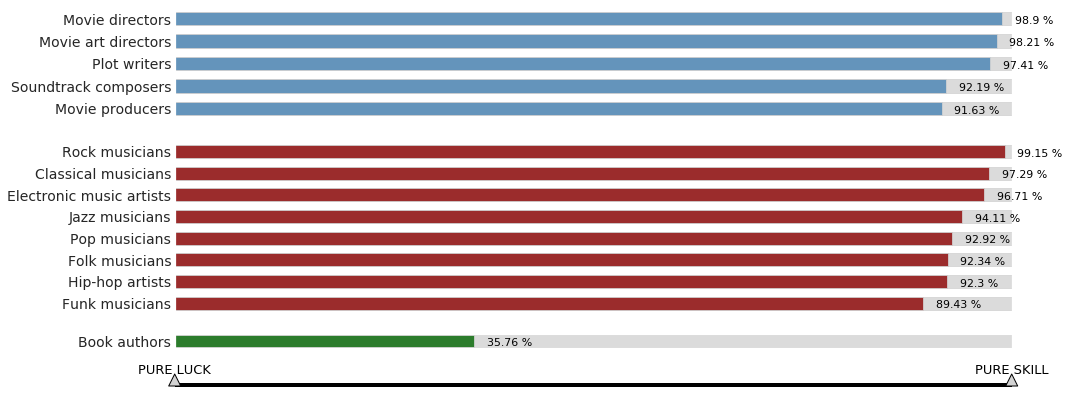

In [233]:
film  = ['writer', 'art_director', 'producer', 'director', 'composer']
book  = ['authors']
music = ['electro', 'pop', 'rock', 'funk', 'folk', 'hiphop', 'jazz', 'classical']


NNN    = 100.0
values = np.arange(0.0,1.0,1.0/NNN)
colors = sns.color_palette("RdBu_r", int(NNN))
values = np.asarray([np.asarray(values), np.asarray(values)])


f = plt.figure(figsize=(15, 7)) 
gs = gridspec.GridSpec(4, 1, height_ratios=[5, 8, 0.6, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])


ax0.set_xlim([0.0,1])
ax1.set_xlim([0.0,1])
ax2.set_xlim([0.0,1])

ax0.get_xaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)


for t in ['top', 'bottom',  'right']:
    ax0.spines[t].set_color('white')
    ax1.spines[t].set_color('white') 
    ax2.spines[t].set_color('white')


xfilm_ls,  yfilm_ls  = zip(*sorted([(field_title[k.replace('_', '-')], v) for k, v in luck_skill_data.items() if k in film],  key=lambda tup: tup[1], reverse = False))
xmusic_ls, ymusic_ls = zip(*sorted([(field_title[k], v) for k, v in luck_skill_data.items() if k in music], key=lambda tup: tup[1], reverse = False))
xbook_ls,  ybook_ls  = zip(*sorted([(field_title[k], v) for k, v in luck_skill_data.items() if k in book], key=lambda tup: tup[1],  reverse = False))

 
ax0.barh(xfilm_ls,  [1.0 for i in range(len(xfilm_ls))],  height = 0.6, edgecolor = 'lightgrey', color = 'lightgrey', alpha = 0.8)
ax1.barh(xmusic_ls, [1.0 for i in range(len(xmusic_ls))], height = 0.6, edgecolor = 'lightgrey', color = 'lightgrey', alpha = 0.8)
ax2.barh(xbook_ls,  [1.0 for i in range(len(xbook_ls))],  height = 0.6, edgecolor = 'lightgrey', color = 'lightgrey', alpha = 0.8)


ax0.barh(xfilm_ls,  yfilm_ls,  height = 0.6, edgecolor = 'lightgrey', color = 'steelblue', alpha = 0.8)
ax1.barh(xmusic_ls, ymusic_ls, height = 0.6, edgecolor = 'lightgrey', color = 'darkred',   alpha = 0.8)
ax2.barh(xbook_ls,  ybook_ls,  height = 0.6, edgecolor = 'lightgrey', color = 'darkgreen', alpha = 0.8)

ax0.set_yticklabels(xfilm_ls,  fontsize=14)
ax1.set_yticklabels(xmusic_ls, fontsize=14)
ax2.set_yticklabels(xbook_ls,  fontsize=14)


for ind, i in enumerate(ax0.patches):
    try:
        ax0.text(yfilm_ls[ind] + 0.015, i.get_y()+0.08, str(round(100*yfilm_ls[ind],2)) + ' %', fontsize=11,color='k')
    except:
        pass
        
for ind, i in enumerate(ax1.patches):
    try:
        ax1.text(ymusic_ls[ind] + 0.015, i.get_y()+0.08, str(round(100*ymusic_ls[ind],2)) + ' %', fontsize=11,   color='k')
    except:
        pass
        
for ind, i in enumerate(ax2.patches):
    try:
        ax2.text(ybook_ls[ind] + 0.015, i.get_y()+0.08, str(round(100*ybook_ls[ind],2)) + ' %', fontsize=11,   color='k')
    except:
        pass

    

    
ax3.axis('off')





ax3.annotate('PURE LUCK', xy=(0, 0.6), xytext=(0, 0.6), horizontalalignment = 'center', 
                fontsize = 13, color ='k',
                arrowprops=dict(facecolor='lightgrey', shrink=0.10,width = 2), )


#ax3.annotate('50% : 50%', xy=(0.5, 0.6), xytext=(0.5, 0.6), horizontalalignment = 'center', 
#                fontsize = 13, color = 'k',
#                arrowprops=dict(facecolor= 'lightgrey', shrink=0.10,width = 2), )



ax3.annotate('PURE SKILL', xy=(1, 0.6), xytext=(1, 0.6), horizontalalignment = 'center', 
                fontsize = 13, color = 'k',
                arrowprops=dict(facecolor= 'lightgrey', shrink=0.10,width = 2), )



ax3.axhline(xmin=0, xmax =1, y=0, color = 'k', linewidth = 8)




for t in ['top', 'left',  'right']:
    ax0.spines[t].set_color('white')
    ax1.spines[t].set_color('white') 
    ax2.spines[t].set_color('white')

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F6.png', bbox_inches="tight")



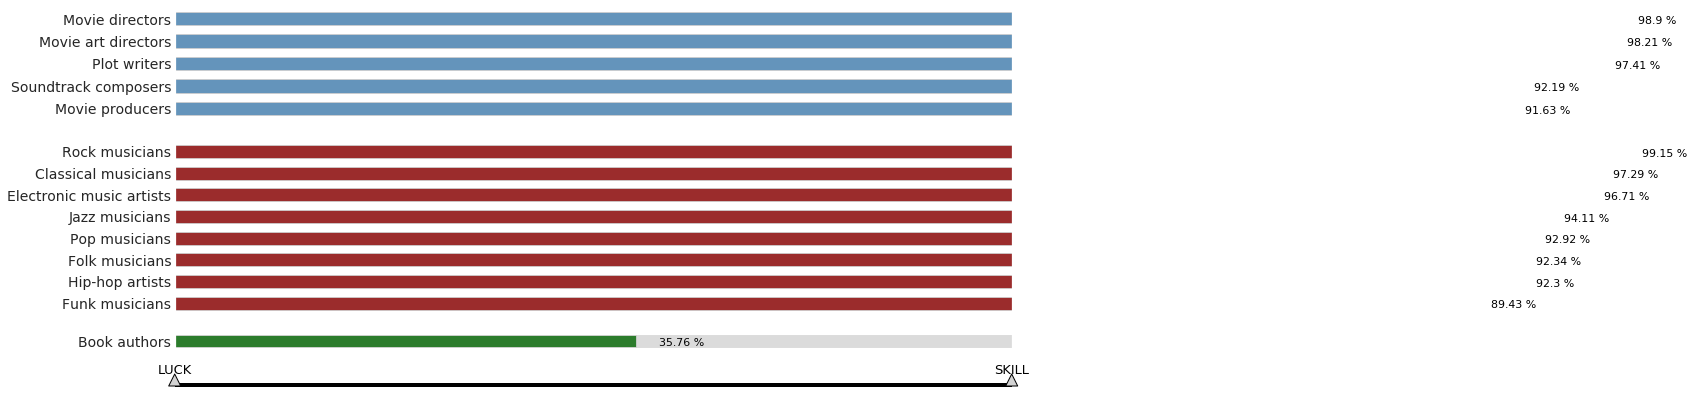

In [234]:
from matplotlib import gridspec


film  = ['writer', 'art_director', 'producer', 'director', 'composer']
book  = ['authors']
music = ['electro', 'pop', 'rock', 'funk', 'folk', 'hiphop', 'jazz', 'classical']


NNN    = 100.0
values = np.arange(0.0,1.0,1.0/NNN)
colors = sns.color_palette("RdBu_r", int(NNN))
values = np.asarray([np.asarray(values), np.asarray(values)])




f = plt.figure(figsize=(15, 7)) 
gs = gridspec.GridSpec(4, 1, height_ratios=[5, 8, 0.6, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])


for axax in [ax0, ax1, ax2]:
    axax.set_xlim([0.0,1])
    axax.set_xlim([0.06,0.6])


ax0.get_xaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)


for t in ['top', 'bottom',  'right']:
    ax0.spines[t].set_color('white')
    ax1.spines[t].set_color('white') 
    ax2.spines[t].set_color('white')


xfilm_ls,  yfilm_ls  = zip(*sorted([(field_title[k.replace('_', '-')], v) for k, v in luck_skill_data.items() if k in film],  key=lambda tup: tup[1], reverse = False))
xmusic_ls, ymusic_ls = zip(*sorted([(field_title[k], v) for k, v in luck_skill_data.items() if k in music], key=lambda tup: tup[1], reverse = False))
xbook_ls,  ybook_ls  = zip(*sorted([(field_title[k], v) for k, v in luck_skill_data.items() if k in book], key=lambda tup: tup[1],  reverse = False))

 
ax0.barh(xfilm_ls,  [1.0 for i in range(len(xfilm_ls))],  height = 0.6, edgecolor = 'lightgrey', color = 'lightgrey', alpha = 0.8)
ax1.barh(xmusic_ls, [1.0 for i in range(len(xmusic_ls))], height = 0.6, edgecolor = 'lightgrey', color = 'lightgrey', alpha = 0.8)
ax2.barh(xbook_ls,  [1.0 for i in range(len(xbook_ls))],  height = 0.6, edgecolor = 'lightgrey', color = 'lightgrey', alpha = 0.8)


ax0.barh(xfilm_ls,  yfilm_ls,  height = 0.6, edgecolor = 'lightgrey', color = 'steelblue', alpha = 0.8)
ax1.barh(xmusic_ls, ymusic_ls, height = 0.6, edgecolor = 'lightgrey', color = 'darkred',   alpha = 0.8)
ax2.barh(xbook_ls,  ybook_ls,  height = 0.6, edgecolor = 'lightgrey', color = 'darkgreen', alpha = 0.8)

ax0.set_yticklabels(xfilm_ls,  fontsize=14)
ax1.set_yticklabels(xmusic_ls, fontsize=14)
ax2.set_yticklabels(xbook_ls,  fontsize=14)


for ind, i in enumerate(ax0.patches):
    try:
        ax0.text(yfilm_ls[ind] + 0.015, i.get_y()+0.08, str(round(100*yfilm_ls[ind],2)) + ' %', fontsize=11,color='k')
    except:
        pass
        
for ind, i in enumerate(ax1.patches):
    try:
        ax1.text(ymusic_ls[ind] + 0.015, i.get_y()+0.08, str(round(100*ymusic_ls[ind],2)) + ' %', fontsize=11,   color='k')
    except:
        pass
        
for ind, i in enumerate(ax2.patches):
    try:
        ax2.text(ybook_ls[ind] + 0.015, i.get_y()+0.08, str(round(100*ybook_ls[ind],2)) + ' %', fontsize=11,   color='k')
    except:
        pass

    

    
ax3.axis('off')





ax3.annotate('LUCK', xy=(0, 0.6), xytext=(0, 0.6), horizontalalignment = 'center', 
                fontsize = 13, color ='k',
                arrowprops=dict(facecolor='lightgrey', shrink=0.10,width = 2), )


#ax3.annotate('50% : 50%', xy=(0.5, 0.6), xytext=(0.5, 0.6), horizontalalignment = 'center', 
#                fontsize = 13, color = 'k',
#                arrowprops=dict(facecolor= 'lightgrey', shrink=0.10,width = 2), )



ax3.annotate('SKILL', xy=(1, 0.6), xytext=(1, 0.6), horizontalalignment = 'center', 
                fontsize = 13, color = 'k',
                arrowprops=dict(facecolor= 'lightgrey', shrink=0.10,width = 2), )


ax3.axhline(xmin=0, xmax =1, y=0, color = 'k', linewidth = 8)



for t in ['top', 'left',  'right']:
    ax0.spines[t].set_color('white')
    ax1.spines[t].set_color('white') 
    ax2.spines[t].set_color('white')

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F6b.png', bbox_inches="tight")


# CORRELATION PLOTS

In [43]:
def read_file(filename):

    return zip(*[[line.strip().split('\t')[0]] + [float(aa.replace(',', '')) for aa in line.strip().split('\t')[1:]] for line in open(filename) if 'https' not in line])

       
f_dir = '../ProcessedData/ProcessedDataNormalized_no/10_multiple_impacts/film_multiple_impacts_director_set.dat'
f_aut = '../ProcessedData/ProcessedDataNormalized_no/10_multiple_impacts/book_multiple_impacts_authors_set.dat'

book,  b_avg, b_cnt, b_edition =  read_file(f_aut)
movie, m_avg, m_cnt, m_meta, m_critic, m_user, m_gross, m_opening = read_file(f_dir)# zip(*[line.strip().split('\t') for line in open(f_dir)])

b_avg    = b_avg[0::100]
b_cnt    = b_cnt[0::100]
m_cnt2   = m_cnt[0::25]
m_critic = m_critic[0::25]
m_user   = m_user[0::25]

10774
10774
6714
6714


/home/milan/.local/lib/python2.7/site-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(self.codes)))


5083
5083
35288
35288


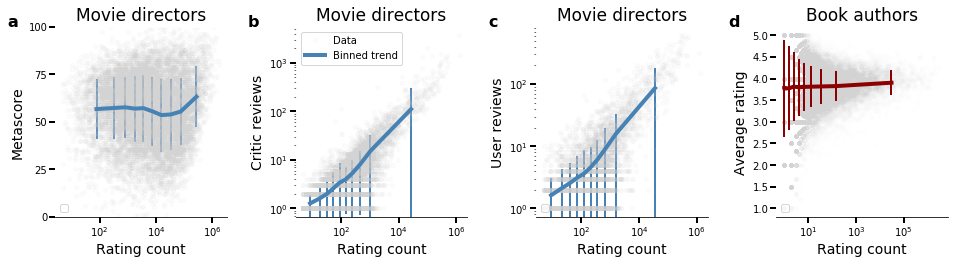

In [45]:
TITLEFONT = 17
LABLEFONT = 14

def plot_corr(x, y, ax, title, xlabel, ylabel, color, color2, yticks = [], logy = False, alpha = 0.06):    

    x, y        = zip(*[(x[i], y[i]) for i in range(len(x)) if x[i] > 0 and y[i]])    
    bx, by, err = getPercentileBinnedDistribution(x, y, 10)
 
    ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    ax.set_xlabel(xlabel, fontsize = LABLEFONT)
    ax.set_ylabel(ylabel, fontsize = LABLEFONT)
    ax.set_title(title, fontsize = TITLEFONT)
    
    if len(yticks) > 0:
        ax.set_ylim([min(yticks), max(yticks)])
        ax.set_yticks([ 0, 25, 50, 75, 100])

        
    ax.tick_params(axis='both', which='major', pad=2)
    ax.legend(loc = 'left', fontsize = 12, frameon = False)
    for pos in ['right', 'top', 'left']: ax.spines[pos].set_edgecolor('white')    

    ax.tick_params(axis='x', length=6, width=2, colors='black')
    ax.tick_params(axis='y', length=6, width=2, colors='black')       
    ax.legend(loc = 'lower left', fontsize = 10)    
              
    ax.plot(x, y, color = 'lightgrey', linewidth = 0, marker = 'o', markersize = 4, alpha = alpha, label = 'Data')
    ax.plot(bx, by,  color = color2, linewidth = 4, alpha= 1.0, label = 'Binned trend') 
    ax.errorbar(bx, by, yerr = err, color = color2, linewidth = 2, alpha= 1.0)

    

fig, ax = plt.subplots(1, 4, figsize=(16, 3.5))

plot_corr(m_cnt, m_meta,    ax[0],  'Movie directors', 'Rating count', 'Metascore',      'steelblue',  'steelblue',  [0, 25, 50, 75, 100])
plot_corr(m_cnt2, m_critic, ax[1],  'Movie directors', 'Rating count', 'Critic reviews', 'steelblue',  'steelblue',  logy = True)
plot_corr(m_cnt2, m_user,   ax[2],  'Movie directors', 'Rating count', 'User reviews',   'steelblue',  'steelblue',  logy = True)
plot_corr(b_cnt, b_avg,     ax[3],  'Book authors',         'Rating count', 'Average rating', 'darkred',   'darkred',    alpha = 0.002)


ax[1].legend(loc = 'upper left', fontsize = 10)
ax[1].legend(loc = 'upper left', fontsize = 10)
  
    
xoff = -0.28      
ax[0].annotate("a", xy=(xoff, 1.0), xycoords="axes fraction", fontsize = 16,  weight="bold")
ax[1].annotate("b", xy=(xoff, 1.0), xycoords="axes fraction", fontsize = 16,  weight="bold")
ax[2].annotate("c", xy=(xoff, 1.0), xycoords="axes fraction", fontsize = 16,  weight="bold")
ax[3].annotate("d", xy=(xoff, 1.0), xycoords="axes fraction", fontsize = 16,  weight="bold")


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F0.png', bbox_inches="tight")

# CAREER EXAMPLES

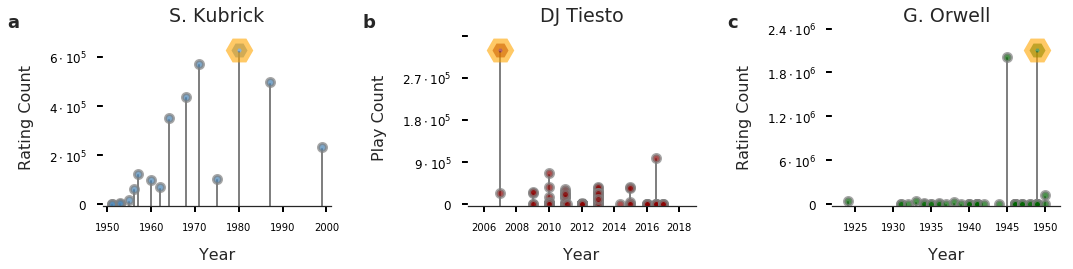

In [15]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
%matplotlib inline 
seaborn.set_style('white')   


TITLEFONT = 19
LABLEFONT = 16

def plot_career(inputfile, name, title, color, ax, title_font, labelsize, font_tick, meas = 3):
  
    data  = []
    for line in open(inputfile):
    
        if 'play' not in line:

            fields  = line.replace(',','').replace('None', '0').strip().split('\t')                
            data.append((float(fields[1]), float(fields[meas]) ))                   


    years,    cnt      = zip(*sorted(data, key=lambda tup: tup[0]))
    (maxyear, maxcnt)  = sorted(data, key=lambda tup: tup[1])[-1]

    LABLEFONT
    [ax.axvline(x = years[ij], ymin = 0, ymax = cnt[ij]/(1.15*maxcnt+0.01*maxcnt),  linewidth = 2, color = 'grey')  for ij in range(len(years))]
    ax.set_title(name, fontsize = TITLEFONT)
    ax.set_xlim([min(years)-2,max(years)+2])
    ax.set_ylim([-0.01*maxcnt,1.15*maxcnt])

    ax.set_xlabel('Year', fontsize  = LABLEFONT, labelpad=15)
    if 'DJ' not in title:
        ax.set_ylabel('Rating Count', fontsize  = LABLEFONT, labelpad=15)

    ax.plot(maxyear,  maxcnt, 'o', color = color, marker= "H", markersize = 16, alpha = 0.6, markeredgecolor='orange', markeredgewidth = 10)#, label = title)
    
    
    years_n = []
    cnt_n   = []
    
    for i in range(len(years)):
        if cnt[i] != maxcnt:
            years_n.append(years[i])
            cnt_n.append(cnt[i])
 
    ax.plot(years_n, cnt_n, 'o', color = color, markersize = 8, alpha = 0.7, markeredgecolor='grey', markeredgewidth = 3)#, linewidth='0' 
    yticks = np.arange(0, 1.15*maxcnt, round(1.15*maxcnt/4, -5 if maxcnt > 500000 else -4))
    
    ax.tick_params(axis='both', which='major', pad=2)
    ax.legend(loc = 'left', fontsize = 12, frameon = False)
    for pos in ['right', 'top', 'left']: ax.spines[pos].set_edgecolor('white')    

    ax.tick_params(axis='x', length=6, width=2, colors='black')
    ax.tick_params(axis='y', length=6, width=2, colors='black')       
    ax.legend(loc = 'lower left', fontsize = 10)    
    
    ax.set_yticks(yticks)  
    ax.set_yticklabels([str(yy/1000).replace('.0', '') + 'k' if len(str(yy).replace('.0', '')) < 7 else str(yy/1000000).replace('.0', '') + 'M' for yy in yticks])#, rotation='vertical')
    
    
 
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

plot_career('../PaperFigures/FinalData/Examples/2_example_kubrick.dat', 'S. Kubrick', 'Star Wars IV', 'steelblue', ax[0], 30, 28, 24)   
plot_career('1602787_pop_simple_career',  'DJ Tiesto', 'Valami', 'darkred', ax[1], 30, 28, 24, 2)   
plot_career('../PaperFigures/FinalData/Examples/2_example_orwell.dat',  'G. Orwell', 'valamike', 'darkgreen', ax[2], 30, 28, 24)   

[ax[j].tick_params(axis='both', which='major', pad=21) for j in range(3)]
    
xoff = -0.5      
ax[0].annotate("a", xy=(-0.42, 1.0), xycoords="axes fraction", fontsize = LABLEFONT+2,     weight="bold")
ax[1].annotate("b", xy=(-0.46, 1.0), xycoords="axes fraction", fontsize = LABLEFONT+2,    weight="bold")
ax[2].annotate("c", xy=(-0.46, 1.0), xycoords="axes fraction", fontsize = LABLEFONT+2,     weight="bold")

ax[0].set_yticklabels(['$0$', '$2 \cdot 10^5$', '$4 \cdot 10^5$',   '$6 \cdot 10^5$'],  fontsize = 12)
ax[1].set_yticklabels(['$0$', '$9 \cdot 10^5$', '$1.8 \cdot 10^5$', '$2.7 \cdot 10^5$'], fontsize = 12)
ax[2].set_yticklabels(['$0$', '$6 \cdot 10^6$', '$1.2 \cdot 10^6$', '$1.8 \cdot 10^6$', '$2.4 \cdot 10^6$'], fontsize = 12)
ax[1].set_ylabel('Play Count', fontsize  = LABLEFONT, labelpad=15)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=None)

for i in range(3):
    ax[i].tick_params(axis='y', which='major', pad=10)
    ax[i].tick_params(axis='x', which='major', pad=10)


#plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F1.png')
plt.show()

# FIGURE 1

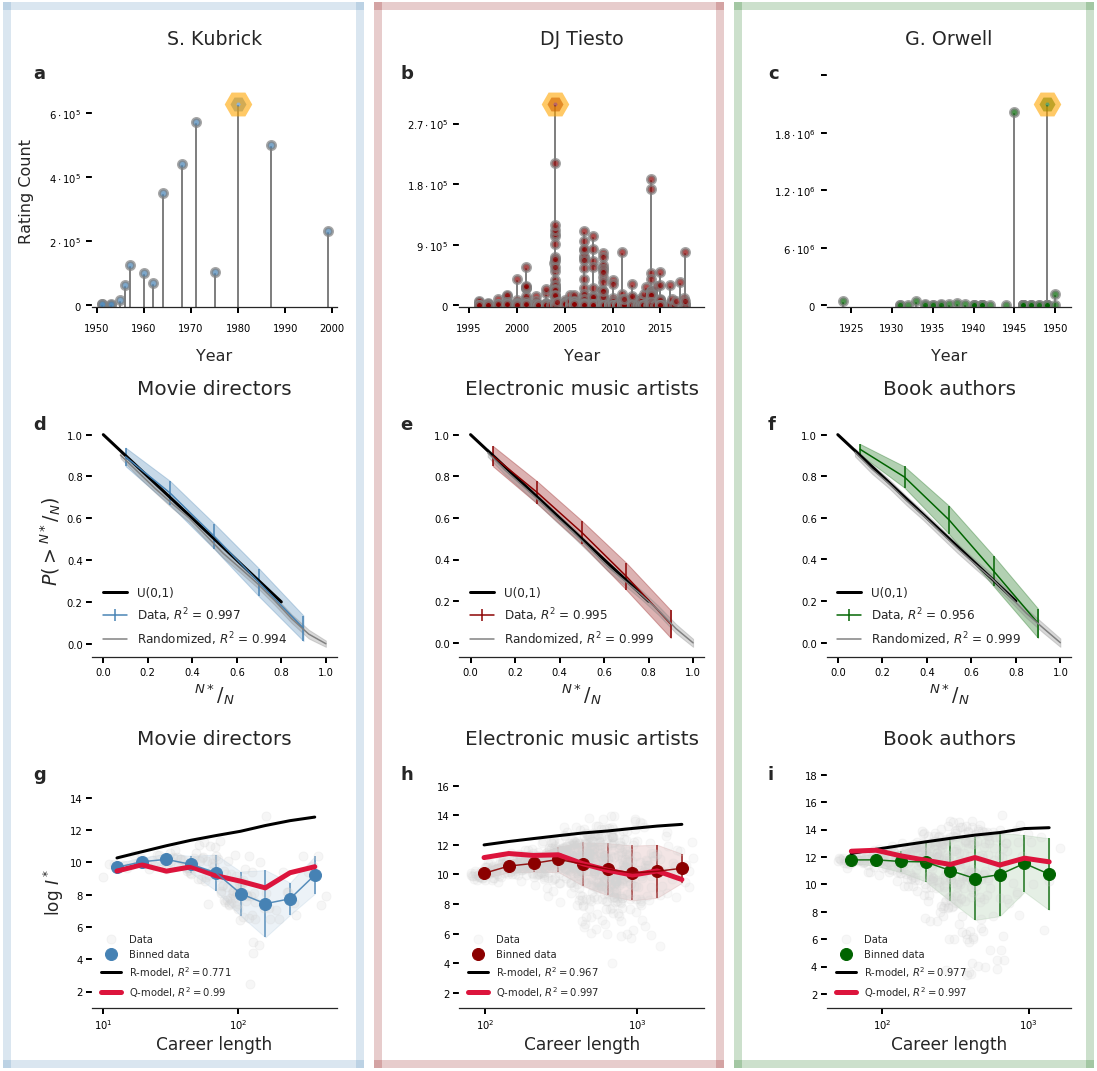

In [108]:
colors = {  'film' :  sns.color_palette("GnBu_d"),
            'book' :  sns.light_palette("green"),         
            'music' :  sns.light_palette("red")}


f, ax = plt.subplots(3,3, figsize = (15,12.5))

colors=["steelblue", "darkred", "darkgreen"]

DELTA = 0.02

for i in range(3):
    outergs = gridspec.GridSpec(1, 1)
    
    x = 0
    y = 0
    if i == 0: x = 0.01
    elif i == 2: y = 0.01    
        
    outergs.update(bottom=0,
                   left=2*(i/float(3))*.5+0.009-x, 
                   top=1.175,
                   right=(2*(i+1)/float(3))*.5-0.008+y)
    
    outerax = f.add_subplot(outergs[0])   
    for direction in ['bottom', 'top', 'right', 'left']: 
        outerax.spines[direction].set_color(colors[i])
        outerax.spines[direction].set_linewidth(8)
        outerax.spines[direction].set_alpha(0.2)
        
  
    outerax.tick_params(axis='both',which='both',bottom=0,left=0, labelbottom=0, labelleft=0)
    outerax.set_facecolor(colors[i])
    outerax.patch.set_alpha(0.0)    
 



plot_career('../PaperFigures/FinalData/Examples/2_example_kubrick.dat', 'S. Kubrick', 'Star Wars IV', 'steelblue', ax[0,0], 30, 28, 24)   
plot_career('../PaperFigures/FinalData/Examples/2_example_tiesto.dat',  'DJ Tiesto', 'Valami', 'darkred',          ax[0,1], 30, 28, 24, 2)   
plot_career('../PaperFigures/FinalData/Examples/2_example_orwell.dat',  'G. Orwell', 'valamike', 'darkgreen',      ax[0,2], 30, 28, 24)   

get_N_star_N_plot_new('director', '10',  field_title['director'], ax[1,0], 'steelblue')
get_N_star_N_plot_new('electro',  '80',  field_title['electro'],  ax[1,1], 'darkred')
get_N_star_N_plot_new('authors',  '50',  field_title['authors'],  ax[1,2], 'darkgreen')

plot_RQmodel('director-10_0',  ax[2,0],  'steelblue'   )  
plot_RQmodel('electro-80_0',   ax[2,1], 'darkred'   )   
plot_RQmodel('authors-50_0',   ax[2,2], 'darkgreen')  

    
    
top  = 0.98
side = 0.24
ax[0,0].annotate("a", xy=(-side, top), xycoords="axes fraction", fontsize = LABLEFONT+2,     weight="bold")
ax[0,1].annotate("b", xy=(-side, top), xycoords="axes fraction", fontsize = LABLEFONT+2,    weight="bold")
ax[0,2].annotate("c", xy=(-side, top), xycoords="axes fraction", fontsize = LABLEFONT+2,     weight="bold")
ax[1,0].annotate("d", xy=(-side, top), xycoords="axes fraction", fontsize = 18,     weight="bold")
ax[1,1].annotate("e", xy=(-side, top), xycoords="axes fraction", fontsize = 18,     weight="bold")
ax[1,2].annotate("f", xy=(-side, top), xycoords="axes fraction", fontsize = 18,     weight="bold")
ax[2,0].annotate("g", xy=(-side, top), xycoords="axes fraction", fontsize = 18,     weight="bold")
ax[2,1].annotate("h", xy=(-side, top), xycoords="axes fraction", fontsize = 18,     weight="bold")
ax[2,2].annotate("i", xy=(-side, top), xycoords="axes fraction", fontsize = 18,     weight="bold")


    

ax[0,0].set_yticklabels(['$0$', '$2 \cdot 10^5$', '$4 \cdot 10^5$',   '$6 \cdot 10^5$'],  fontsize = 10)
ax[0,1].set_yticklabels(['$0$', '$9 \cdot 10^5$', '$1.8 \cdot 10^5$', '$2.7 \cdot 10^5$'], fontsize = 10)
ax[0,2].set_yticklabels(['$0$', '$6 \cdot 10^6$', '$1.2 \cdot 10^6$', '$1.8 \cdot 10^6$'], fontsize = 10)
#ax[0,2].set_yticklabels(['$0$', '$6 \cdot 10^6$', '$1.2 \cdot 10^6$', '$1.8 \cdot 10^6$', '$2.4 \cdot 10^6$'], fontsize = 10)

ax[0,1].set_ylabel('Play Count', fontsize  = LABLEFONT, labelpad=15)


for i in range(3):
    ax[0,i].tick_params(axis='y', which='major', pad=5)
    ax[0,i].tick_params(axis='x', which='major', pad=10)

[ax[j,i].set_ylabel('') for i in range(1,3) for j in range(3)]

plt.tight_layout()    
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.1, wspace=0.5, hspace=0.5)
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/Figure1.png', bbox_inches="tight")

# FIGURE 2

In [2]:
colors_f = {}
colors_s = {}
colors_b = {}

for ind in range(9):
    colors_f[ind]= sns.color_palette("Blues",  10)[ind]
    colors_s[ind]= sns.color_palette("Reds",   10)[ind]
    colors_b[ind]= sns.color_palette("Greens", 10)[ind]
   
colors_f[ind+1] =  sns.color_palette("Blues", 10)[-1]
colors_s[ind+1] =  sns.color_palette("Reds", 10)[-1]
colors_b[ind+1] =  sns.color_palette("Greens", 10)[-1]

colors_dicts = [colors_f, colors_s, colors_b]

../PRIZEPREDICTION/PredictionResults/100/director_pred_results_film_oscar_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/electro_pred_results_music_grammies_095_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/authors_pred_results_books_nobel_R=100.dat


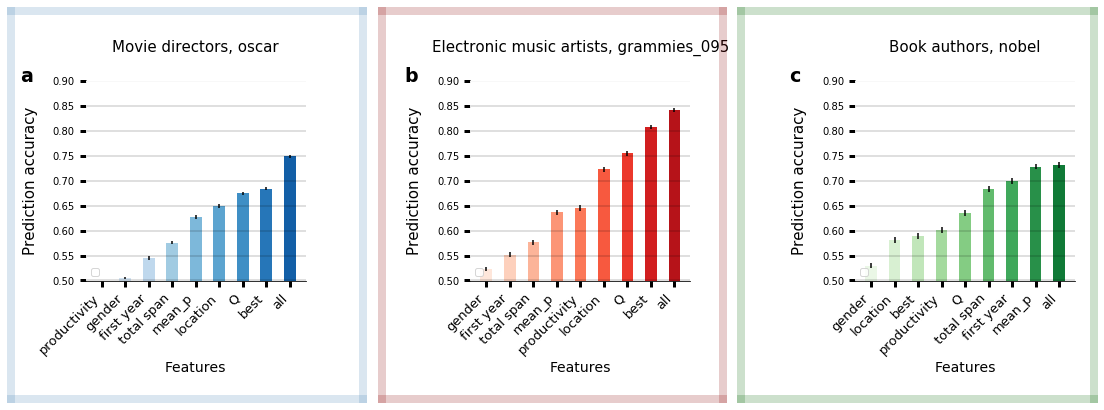

In [4]:
def plot_prize_pred(field, R, ax, colorid,fieldd, prize, title):
    
    

    filename = '../PRIZEPREDICTION/PredictionResults/' + str(R) + '/' + field + '_pred_results_' +  fieldd + '_' + prize + '_R=' + str(R) + '.dat'

    features   = []
    errors     = []
    accuracies = []
    
    for line in open(filename):
        if 'best_acc' not in line:
            feature, best_acc, error, max_depth, learning_rate, subsample_size = line.strip().split('\t')
            accuracies.append(float(best_acc))
            errors.append(float(error))
            features.append(feature)
            
            
    triple = [(features[i], accuracies[i], errors[i]) for i in range((len(accuracies))) ]
    triple.sort(key=lambda tup: tup[1])
    features, accuracies, errors = zip(*triple )
    
    print filename
    
    ax.bar(features, accuracies, yerr = errors, width = 0.5, color = colors_dicts[colorid].values())

    
    ax.set_ylim([0.5, 0.9])
    ax.set_xlabel('Features', fontsize = 14)
    ax.set_ylabel('Prediction accuracy', fontsize = 15, labelpad=15)

    for pos in ['right', 'top', 'left']:
        ax.spines[pos].set_edgecolor('white')    

    ax.tick_params(axis='x', length=6, width=3, colors='black')
    ax.tick_params(axis='y', length=6, width=3, colors='black')       
    ax.legend(loc = 'lower left', fontsize = 10)
    ax.grid(False)
    ax.yaxis.grid(linewidth = 0.25) 
    ax.set_xticklabels(features, fontsize = 13, rotation = 45, ha = 'right')

    ax.set_title(title + ', ' + prize, fontsize = 15)
    ax.yaxis.grid(linewidth = 0.25, color = 'k') 



    




f, ax = plt.subplots(1,3, figsize = (15,5))

colors=["steelblue", "darkred", "darkgreen"]

DELTA = 0.02

for i in range(3):
    outergs = gridspec.GridSpec(1, 1)    
    x = 0
    y = 0
    if i == 0: x = 0.01
    elif i == 2: y = 0.01    
        
    outergs.update(bottom=-0.03,
                   left=2*(i/float(3))*.5+0.009-x, 
                   top=1.05,
                   right=(2*(i+1)/float(3))*.5-0.008+y)
    
    outerax = f.add_subplot(outergs[0])   
    for direction in ['bottom', 'top', 'right', 'left']: 
        outerax.spines[direction].set_color(colors[i])
        outerax.spines[direction].set_linewidth(8)
        outerax.spines[direction].set_alpha(0.2)
        
  
    outerax.tick_params(axis='both',which='both',bottom=0,left=0, labelbottom=0, labelleft=0)
    outerax.set_facecolor(colors[i])
    outerax.patch.set_alpha(0.0)    
 


        

R = 100
    
plot_prize_pred('director', R, ax[0], 0, 'film',  'oscar',        field_title['director'])
plot_prize_pred('electro',  R, ax[1], 1, 'music', 'grammies_095', field_title['electro'])
plot_prize_pred('authors',  R, ax[2], 2, 'books', 'nobel',     field_title['authors'])


ax[0].annotate("a", xy=(-0.30, 1.0), xycoords="axes fraction", fontsize = 17+2,    weight="bold")
ax[1].annotate("b", xy=(-0.30, 1.0), xycoords="axes fraction", fontsize = 17+2,    weight="bold")
ax[2].annotate("c", xy=(-0.30, 1.0), xycoords="axes fraction", fontsize = 17+2,    weight="bold")


for j in range(3): ax[j].tick_params(axis='both', which='major', pad=5)

rcParams['axes.titlepad'] = 30 
        


plt.tight_layout()
plt.subplots_adjust(left=None, bottom=0.3, right=None, top=None, wspace=0.75, hspace=None)
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/Figure2.png', bbox_inches="tight")

../PRIZEPREDICTION/PredictionResults/100/director_pred_results_film_oscar_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/producer_pred_results_film_oscar_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/writer_pred_results_film_oscar_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/composer_pred_results_film_oscar_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/art_director_pred_results_film_oscar_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/authors_pred_results_books_pulitzer_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/authors_pred_results_books_nobel_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/electro_pred_results_music_grammies_09_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/electro_pred_results_music_grammies_095_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/pop_pred_results_music_grammies_09_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/pop_pred_results_music_grammies_095_R=100.dat
../PRIZEPREDICTION/PredictionResults/100/rock_pred_re

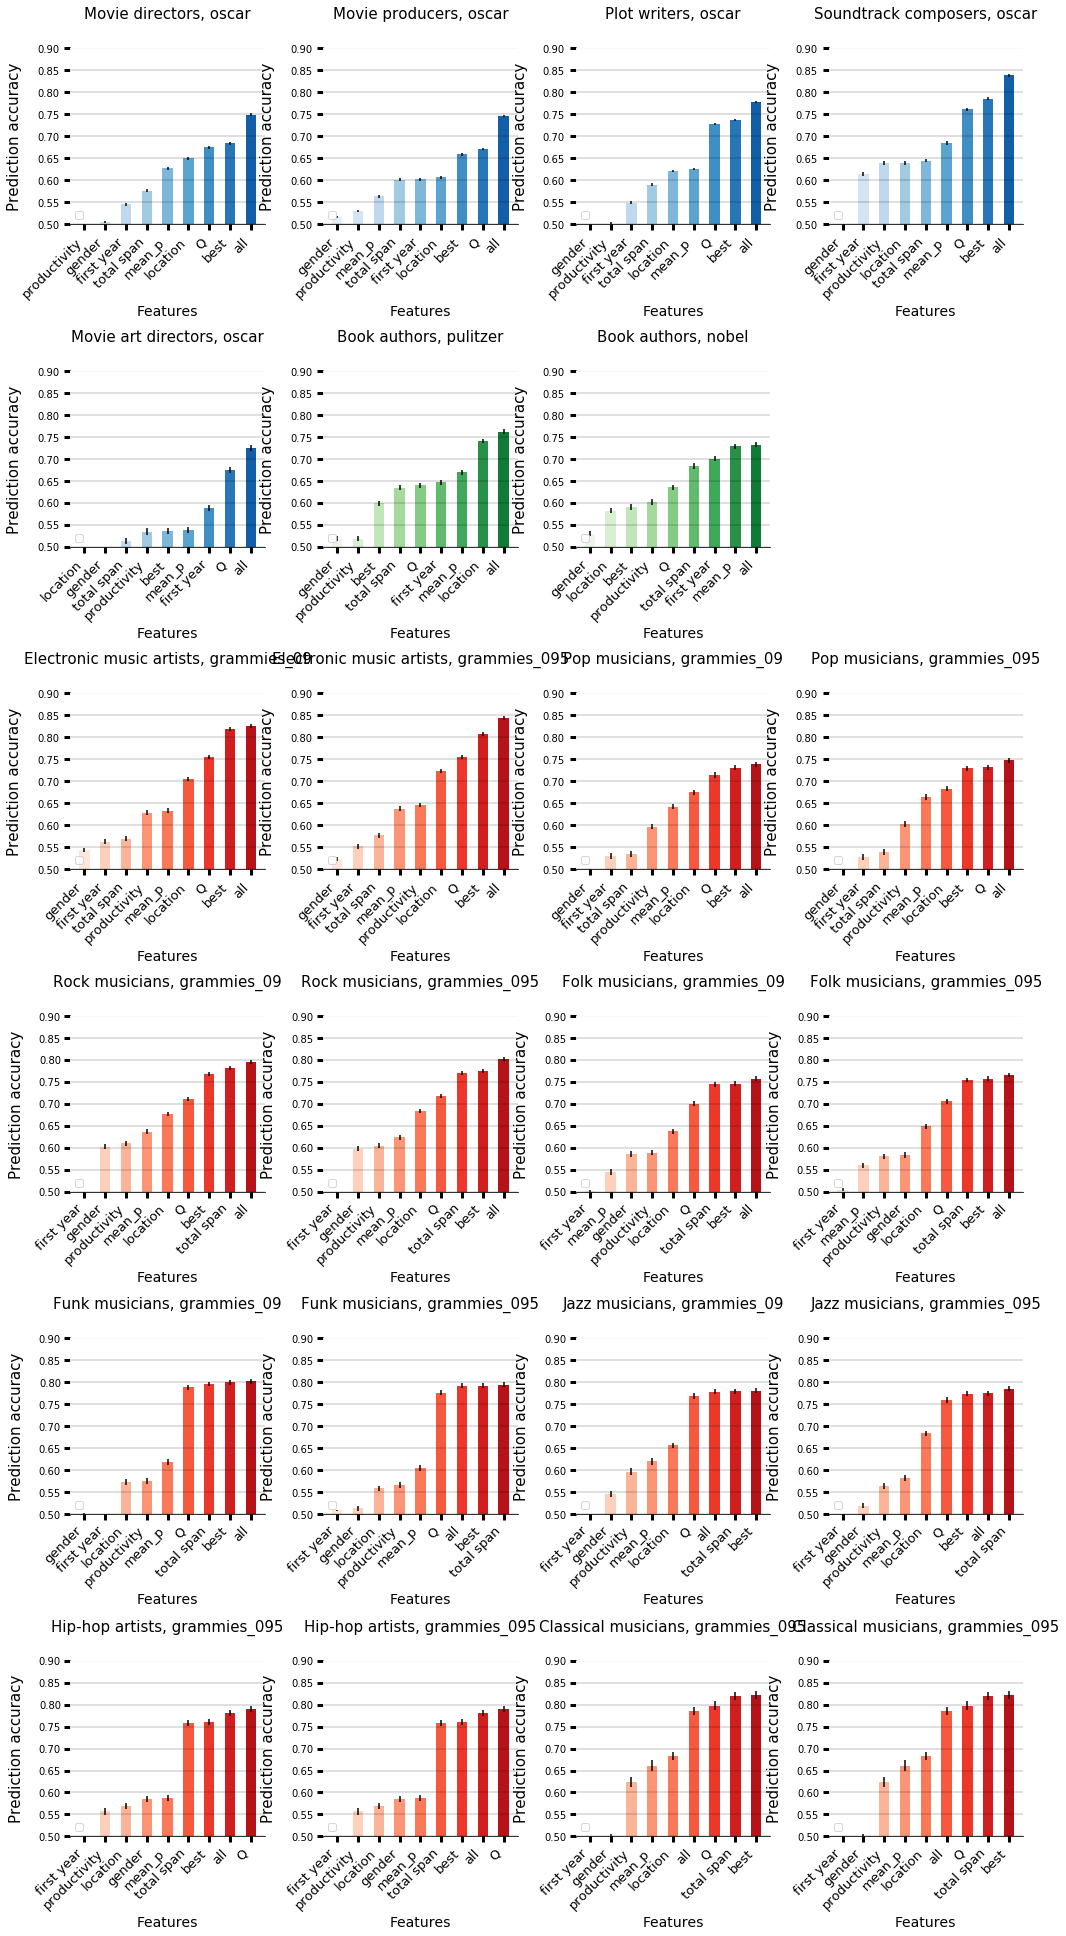

In [5]:
f, ax = plt.subplots(6,4,figsize = (15,27))  


plot_prize_pred('director',     R, ax[0,0], 0, 'film',  'oscar',        field_title['director'])
plot_prize_pred('producer',     R, ax[0,1], 0, 'film',  'oscar',        field_title['producer'])
plot_prize_pred('writer',       R, ax[0,2], 0, 'film',  'oscar',        field_title['writer'])
plot_prize_pred('composer',     R, ax[0,3], 0, 'film',  'oscar',        field_title['composer'])
plot_prize_pred('art_director', R, ax[1,0], 0, 'film',  'oscar',        field_title['art-director'])


plot_prize_pred('authors',   R, ax[1,1], 2, 'books', 'pulitzer',     field_title['authors'])
plot_prize_pred('authors',   R, ax[1,2], 2, 'books', 'nobel',     field_title['authors'])
ax[1,3].axis('off')

plot_prize_pred('electro',   R, ax[2,0], 1, 'music', 'grammies_09', field_title['electro'])
plot_prize_pred('electro',   R, ax[2,1], 1, 'music', 'grammies_095', field_title['electro'])

plot_prize_pred('pop',       R, ax[2,2], 1, 'music', 'grammies_09', field_title['pop'])
plot_prize_pred('pop',       R, ax[2,3], 1, 'music', 'grammies_095', field_title['pop'])

plot_prize_pred('rock',      R, ax[3,0], 1, 'music', 'grammies_09', field_title['rock'])
plot_prize_pred('rock',      R, ax[3,1], 1, 'music', 'grammies_095', field_title['rock'])

plot_prize_pred('folk',      R, ax[3,2], 1, 'music', 'grammies_09', field_title['folk'])
plot_prize_pred('folk',      R, ax[3,3], 1, 'music', 'grammies_095', field_title['folk'])


plot_prize_pred('funk',      R, ax[4,0], 1, 'music', 'grammies_09',  field_title['funk'])
plot_prize_pred('funk',      R, ax[4,1], 1, 'music', 'grammies_095', field_title['funk'])

plot_prize_pred('jazz',      R, ax[4,2], 1, 'music', 'grammies_09',  field_title['jazz'])
plot_prize_pred('jazz',      R, ax[4,3], 1, 'music', 'grammies_095', field_title['jazz'])
               
                       
plot_prize_pred('hiphop',    R, ax[5,0], 1, 'music', 'grammies_095', field_title['hiphop'])
plot_prize_pred('hiphop',    R, ax[5,1], 1, 'music', 'grammies_095', field_title['hiphop'])

plot_prize_pred('classical', R, ax[5,2], 1, 'music', 'grammies_095', field_title['classical'])
plot_prize_pred('classical', R, ax[5,3], 1, 'music', 'grammies_095', field_title['classical'])



[ax[i,j].tick_params(axis='both', which='major', pad=5) for j in range(4) for i in range(3)]

rcParams['axes.titlepad'] = 30 
    

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


# FIGURE 3

In [235]:
colors_field =  {    'art_director': 'steelblue',
                     'authors'     : 'darkgreen', 
                     'classical'   : 'darkred',
                     'composer'    : 'steelblue',
                     'director'    : 'steelblue',
                     'electro'     : 'darkred',
                     'folk'        : 'darkred',
                     'funk'        : 'darkred',
                     'hiphop'      : 'darkred',
                     'jazz'        : 'darkred',
                     'pop'         : 'darkred',
                     'producer'    : 'steelblue',
                     'rock'        : 'darkred',
                     'writer'      : 'steelblue'}
pdata = {}
qdata = {}

for line in open('DataToPlot/5_LuckSkill/p_avg_std.dat'):
    if '0_0.dat' in line:
        line  = line.strip().split('\t')
        field = line[0].replace('p_distribution_', '').rsplit('_', 1)[0]
        pavg  = float(line[1])
        pstd  = float(line[2])
        pdata[field] = pstd / pavg
        
        
for line in open('DataToPlot/5_LuckSkill/Q_avg_std.dat'):
    if '0_0.dat' in line:
        line  = line.strip().split('\t')
        field = line[0].replace('Q_distribution_', '').rsplit('_', 1)[0]
        qavg  = float(line[1])
        qstd  = float(line[2])                                                            
        qdata[field] = qstd #/ qavg)**2
      
final_keys = ['art_director-20', 'authors-50','classical-80', 'composer-10', 'director-10', 'electro-80', 'folk-80',
             'funk-80', 'hiphop-80', 'jazz-80', 'pop-80', 'producer-10', 'rock-80', 'writer-10' ]

luck_skill_data = {}

for field in final_keys:   
    luck_skill_data[field.split('-')[0]] =  qdata[field] / (pdata[field] + qdata[field])
    
luck_skill_data  

{'art_director': 0.9986388702978276,
 'authors': 0.9755908342893395,
 'classical': 0.9962449322043917,
 'composer': 0.9914021203375565,
 'director': 0.9979526540804456,
 'electro': 0.9969446002385167,
 'folk': 0.992670157195106,
 'funk': 0.9933224808814075,
 'hiphop': 0.994259461031479,
 'jazz': 0.9942075980761428,
 'pop': 0.9909087245887332,
 'producer': 0.9959255578754752,
 'rock': 0.9983614939633554,
 'writer': 0.9976393184733704}

In [1]:
NNN    = 200.0
values = np.arange(0.0,1.0,1.0/NNN)
f, ax  = plt.subplots(1,1, figsize = (15,1))
colors = sns.color_palette("RdBu_r", int(NNN))
values = np.asarray([np.asarray(values), np.asarray(values)])

sns.heatmap(values, cmap=colors,  ax = ax, vmin=0, vmax = 1,linewidths = 0, cbar= False)
ax.axis('off')



actual_data = luck_skill_data
ypositions  = {k : 0.0001 for k, v in actual_data.items()}

ypositions['classical']      = 1.7
ypositions['electro']        = 1
ypositions['jazz']           = -6.1
ypositions['producer']       = 1.7
ypositions['art_director']   = -5.1
ypositions['composer']       = -6.0
ypositions['rock']           = 2.3
ypositions['pop']            = 1.0
ypositions['folk']           = 0.5
ypositions['authors']        = 0.5


for ind, (title, val) in enumerate(actual_data.items()):

    xcoord = val * NNN
    
    ax.axvline(x=xcoord, ymin=-0.5, ymax=5.5, color = 'k', linewidth = 5)
  
    ax.annotate(title, xy=(xcoord,  2), xytext=(xcoord, 4.5 + ypositions[title]), 
                horizontalalignment = 'center', 
                fontsize = 14,
                color    = colors_field[title],
                arrowprops=dict(facecolor=colors[int(xcoord)], shrink=0.15,width = 1),)
    
 
ax.axvline(x=0, ymin=-0.5, ymax=5.5, color = 'k', linewidth = 10)
ax.annotate('PURE LUCK', xy=(0, 2), xytext=(0, 4.5), horizontalalignment = 'center', 
                fontsize = 14, color =colors[0],
                arrowprops=dict(facecolor=colors[0], shrink=0.15,width = 3), )

ax.axvline(x=NNN, ymin=-0.5, ymax=5.5, color = 'k', linewidth = 10)
ax.annotate('PURE SKILL', xy=(NNN, 2), xytext=(NNN, 4.5), horizontalalignment = 'center', 
                fontsize = 14, color =colors[-1],
                arrowprops=dict(facecolor=colors[-1], shrink=0.15,width = 3), )

#plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/Figure3.png', bbox_inches="tight")

NameError: name 'np' is not defined

# Figure 4

In [202]:
fields_data = [('director','film',  'oscar'),
              ('producer','film',  'oscar'),
              ('writer','film',  'oscar'),
              ('composer','film',  'oscar'),
              ('art_director','film',  'oscar'),
              ('electro',   'music',  'grammies_095'),
              ('pop',       'music',  'grammies_095'),
              ('rock',      'music',  'grammies_095'),
              ('folk',      'music',  'grammies_095'),
              ('funk',      'music',  'grammies_095'),
              ('hiphop',    'music',  'grammies_095'),
              ('jazz',      'music',  'grammies_095'),
              ('classical', 'music',  'grammies_095'),
              ('authors', 'books',  'pulitzer')
             # ('authors', 'books',  'nobel')   
            ]    

Text(0.5,1,'R^2 =0.0254')

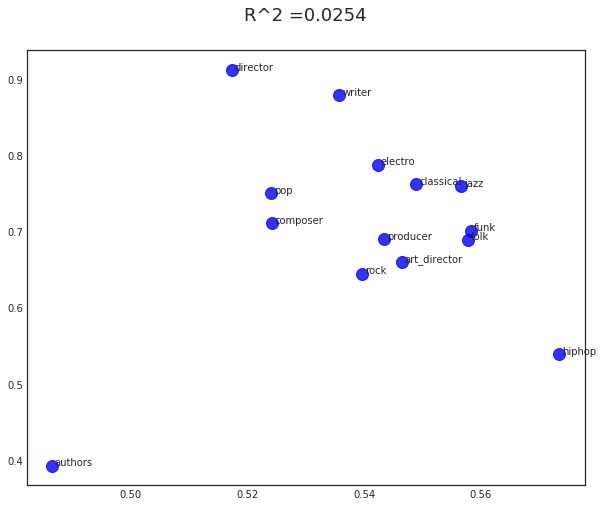

In [203]:
def get_p_Q_pred_power(profession, field, prize, R):

    filename = '../PRIZEPREDICTION/PredictionResults/' + str(R) + '/' + profession + '_pred_results_' +  field + '_' + prize + '_R=' + str(R) + '.dat'

    Q = 0
    p = 0
    
    for line in open(filename):
        
        if 'Q' in line: 
            Q = float(line.strip().split('\t')[1])
            
        elif 'mean_p' in line:
            p = float(line.strip().split('\t')[1])
            
    return Q/(Q+p)



luck_skill_pred = {}    
    
for (prof, field, prize) in fields_data:  
    luck_skill_pred[prof] = get_p_Q_pred_power(prof, field, prize, R)

    

f, ax = plt.subplots(1,1,figsize=(10,8))
x = []
y = []
z = []
for field, val1 in luck_skill_data.items():

    #if 'auth' not in field:

    y.append(val1)
    x.append(luck_skill_pred[field])
    z.append(field)

    
for i, txt in enumerate(z):  ax.annotate(txt, (x[i]+0.0005, y[i]+0.0005))    
    
ax.plot(x,y, 'bo', markersize = 12, alpha = 0.8)

ax.set_title('R^2 =' + str(round(rsquared(x,y),4)), fontsize = 18)